# IBM Open Science prize challenge

## Final results
For this solution the decision was to use the Qiskit Pulse for the IBM open science prize 2021 challenge, this module allowed us to explore the possibilities of precise quantum control.

The best achieved fidelity for the full state tomography on the ibmq_jakarta were:
1. **0.8437** fidelity with zero noise extrapolation (fidelity without error mitigation techniques, but including measurement filter was 0.5278). The experiment was run on 20th March 2022 (job id: 623754a3d97bff37d8693572). The circuit was based on:
    * 11 Trotter steps,
    * using RZX based circuit design,
    * having additional calibration runs using qiskit calibration routines,
    * including Carr-Purcel dynamical decoupling sequence with 4 pulses per sequence,
    * with a custom measurement classifier based on k-Nearest Neighbors algorithm and modified amplitudes of default measurement pulses.
    * a measurement filter was applied.
    * Zero noise extrapolation was done based on 6 full tomography scans with different noise scales.
    
<br/>

2. **0.8260** and **0.8107** fidelity for a similar circuit as above but run on 26th March 2022 (job id: 623ec33ba2f72d3234dabd1a and 623ec0c974de0e833f85b645). All the settings were the same as above with the exception that no additional calibration routines were run (due to high queue on the machine) and 10 full tomography scans were used for the ZNE.

For the full details of the design circuit and results from other experiments please refer to the included paper:
### [<font color="blue">IBM open science 2021.pdf</font>](IBM%20open%20science%202021.pdf)

<br/>

This paper explores techniques which were not inclued in this notebook due to poor performance or not enough benchmarking time:
- Piecewise constant optimization.
- RZX fine tunning.
- Custom X, SX gate schedules like SCROFULOUS, CORPSE, SK1, etc.
- Algorithmic errors mittigation.

### Initial setup

Include all needed libraries

In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, schedule, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

import pandas as pd

import random

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal
from qiskit_experiments.library.calibration.frequency_cal import FrequencyCal
from qiskit_experiments.library.calibration.fine_frequency_cal import FineFrequencyCal

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit.tools.monitor import job_monitor

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

from qiskit import transpile, schedule as build_schedule, QuantumRegister, ClassicalRegister
from qiskit.pulse import Schedule, Play, SetFrequency, Drag, Gaussian, ShiftFrequency, GaussianSquare, DriveChannel, ControlChannel, Waveform, ScheduleBlock, Acquire, AcquireChannel, MemorySlot, MeasureChannel, Delay
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter, Gate

from qiskit.circuit import Instruction

# based on https://stackoverflow.com/questions/49503869/attributeerror-while-trying-to-load-the-pickled-matplotlib-figure
def show_figure(fig):
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
    
# based on https://www.delftstack.com/howto/python/parallel-for-loops-python/
import asyncio
import time

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

d = lambda idx: pulse.DriveChannel(idx)
m = lambda idx: pulse.MeasureChannel(idx)
u = lambda idx: pulse.ControlChannel(idx)
a = lambda idx: pulse.AcquireChannel(idx)

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
backend = provider.get_backend('ibmq_jakarta')

config = backend.configuration() # configuration - Hardware configuration information.
properties = backend.properties() # properties - Physical properties of the device.
defaults = backend.defaults() # defaults - Information for pulse properties that change frequently.

from qiskit.opflow import Zero, One, I, X, Y, Z

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_histogram

from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho, RZXCalibrationBuilder

from qiskit.circuit.library import XGate, YGate, SXGate, RZGate

from qiskit.visualization.pulse_v2 import draw, IQXDebugging

import time
from tqdm import tqdm_notebook as tqdm

from scipy.optimize import curve_fit
import copy

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 f

#### Utils

Additional functions to handle instruction maps update and calibration objects.

In [3]:
# dispaly the schedules paramters
def display_gates_pulses(instructions, qubits, inst_map):
    for qubit in qubits:
        for instruction in instructions:
            print(inst_map.get(instruction, qubit))

# Function which update the Drag pulse parameters in the instruction_map (inst_map)
def update_drag_parameter(qubit, instruction, parameter, new_value, inst_map):
    
    # Get the instruction to update from the inst_map. Using the .pop function we remove the specific instruction from our global inst_map.
    old_sched = inst_map.pop(instruction, qubit)
    
    # Instructions are returned in a tuple (<time_value>, <Instruction>) and all Drag pulses are combined in Play instruction. So we look for Play instruction, with its pulse (operand) set to Drag.
    for instr_ in old_sched.instructions:
        if isinstance(instr_[1], pulse.instructions.play.Play):
            if isinstance(instr_[1].operands[0], pulse.Drag):
                
                # We copy all Drag parameters to local objects with the exception of the parameter which we want to update - this parameter is taken from the function argument.
                duration = new_value if parameter == 'duration' else instr_[1].operands[0].duration
                amp = new_value if parameter == 'amp' else instr_[1].operands[0].amp
                sigma = new_value if parameter == 'sigma' else instr_[1].operands[0].sigma
                beta = new_value if parameter == 'beta' else instr_[1].operands[0].beta
                name = new_value if parameter == 'name' else instr_[1].operands[0].name
    
    # We create a new empty schedule.
    new_sched = Schedule()
    # To which we add a Play instruction with Drag pulse with our local parameters
    new_sched += Play(Drag(duration, amp, sigma, beta, name), d(qubit))    
    inst_map.add(instruction, qubit, new_sched)
    
# Function to update calibration object based on instruction map
def update_cal_from_inst_map(qubits, instructions, cal, inst_map):
    
    # The function can be called with an array of qubits and instructions to update.
    for qubit in qubits:
        for instruction in instructions:
            
            # We make a schedule copy of the global instruction map.
            sched = inst_map.get(instruction, qubit)
            for instr_ in sched.instructions:
                if isinstance(instr_[1], pulse.instructions.play.Play):
                    
                    # We iterate through the instruction to find the Drag Pulse.
                    if isinstance(instr_[1].operands[0], pulse.Drag):
                        
                        # We copy the Drag Pulse parameters from the instruction map to local objects.
                        duration = instr_[1].operands[0].duration
                        amp = instr_[1].operands[0].amp
                        sigma = instr_[1].operands[0].sigma
                        beta = instr_[1].operands[0].beta
                        name = instr_[1].operands[0].name
                        
                        # We update the calibration with the local Drag parameters.
                        cal.add_parameter_value(amp, 'amp', qubit, instruction)
                        cal.add_parameter_value(duration, 'duration', qubit, instruction)
                        cal.add_parameter_value(sigma, 'σ', qubit, instruction)
                        cal.add_parameter_value(beta, 'β', qubit, instruction)    
    
# Function to update instruction maps based on calibration parameters.
def update_inst_map_from_cal(qubits, instructions, cal, inst_map):
    
    # The function can be called with an array of qubits and instructions to update.
    for qubit in qubits:
        for instruction in instructions:
            
            # We use our previously defined update_drag_paramers util function. The actual calibration parameters can be easily obtained using the .get_parameter_value() function.
            update_drag_parameter(qubit, instruction, 'amp', cal.get_parameter_value('amp', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'beta', cal.get_parameter_value('β', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'sigma', cal.get_parameter_value('σ', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'duration', cal.get_parameter_value('duration', qubit, instruction), inst_map)


#### Setup

Define the qubits on the quantum hardware.

Create `InstructionScheduleMap` objects which will contain the gate schedules which we will use in our circuits.

In [4]:
qubits = [0, 1, 2, 3, 4, 5, 6]

# set the experted duraiton for SX & X.
# 10*16 is the default ibm value
duration = 10*16

inst_map_cal = pulse.InstructionScheduleMap() # instruction map with tunned ibm calibration settings
inst_map_ncal = pulse.InstructionScheduleMap() # instruction map with default ibm calibration settings

# copy the default parameters to inst_map_{cal & ncal}
for instruction in defaults.instruction_schedule_map.instructions:
    if instruction not in  ['cx', 'u1', 'u2', 'u3']:
        for qubit in qubits:
            inst_map_cal.add(instruction, qubit, defaults.instruction_schedule_map.get(instruction, qubit))
            inst_map_ncal.add(instruction, qubit, defaults.instruction_schedule_map.get(instruction, qubit))
            
inst_map_cal.add('measure', range(config.n_qubits), 
             defaults.instruction_schedule_map.get('measure', range(config.n_qubits)))
inst_map_ncal.add('measure', range(config.n_qubits), 
             defaults.instruction_schedule_map.get('measure', range(config.n_qubits)))

# copy the needed CNOT parameters
cx_qubits = [(1,3), (3,1), (3,5), (5, 3)]
for qubit in cx_qubits:
    inst_map_cal.add('cx', qubit, defaults.instruction_schedule_map.get('cx', qubit))
    inst_map_ncal.add('cx', qubit, defaults.instruction_schedule_map.get('cx', qubit))

# update the duration parameters for the SX & X gates.
for instruction in ['sx','x']:
    for qubit in qubits:
        update_drag_parameter(qubit, instruction, 'duration', duration, inst_map_cal)

### Gates Fine tunning

Qiskit provides built-in calibration routines for the single qubit gates - X and SX gates.

We used this routine to fine tune the gates with extended circuits count (from the default settings).

Fine tuning gives us around **1-3%** improvement in the overall simulation. This results depends on when the automatic calibration of the quantum computer was done. With longer wait time between automatic calibration running additional fine tuning calibration routine has the highest gains.

We decided to not perform qubit frequency calibration due to impact on the default ibm calibration. Changing qubit frequency without fine tuning results in lower fidelity.

We additionaly benchmarked predefine pulse schedules like `SCROFULOUS`, `WAMF1`, `CORPSE`, etc. but they were ommited from this notebook due to need for manual calibration.

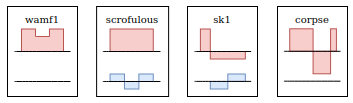

#### Create calibration

In [11]:
import os

# function to save the calibration on the local drive.
def save_calibration(cals):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    
    if not os.path.exists("./gates_calibration"):
        os.makedirs("./gates_calibration")
        
    calibration_dir = "./gates_calibration/" + timestr
    if not os.path.exists(calibration_dir):
        os.makedirs(calibration_dir)
    cals.save(folder=calibration_dir, overwrite=True)

##### **Amplitude calibration**

`Fine<X,SX>AmplidueCal` routine provides an easy interface to calibrate `X` and `SX` gates amplitudes.

For X calibration we need to create the circuits which will result in the superposition state, that is circuits with a single SX gate, SX and X gates, SX and two X gates, etc:

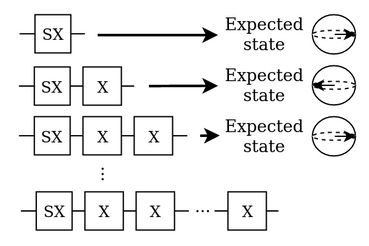


Uncalibrated results shows a divergence in the measured state:

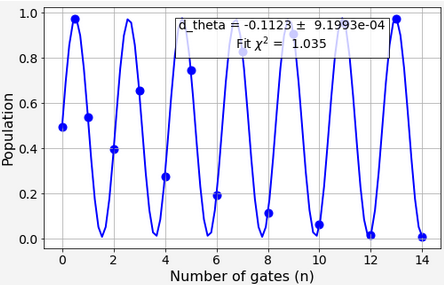


Where the calibrated gate shows that the number of excited state vs ground states is less susceptible to the number of gates in the circuit:

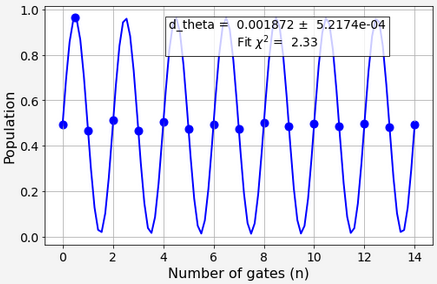

In [41]:
# Import the Amplitude calibration functions from qiskit libraries.
from qiskit_experiments.library.calibration.fine_amplitude import FineXAmplitudeCal, FineSXAmplitudeCal

# Create a calibration object (dummy_cals) with default backend settings.
library = FixedFrequencyTransmon(default_values={"duration": duration})
dummy_cals = Calibrations.from_backend(backend, library)

# Copy the previous calibration (inst_map_cal) to experiment calibration (dummy_cals).
update_cal_from_inst_map(qubits, ['sx','x'], dummy_cals, inst_map_cal)

# Structures for storing the job results in case further analysis is needed.
jobs_data_amp_x = []
jobs_data_amp_sx = []

# Function to combine X and SX amplitude calibration.
def FineAmplitudeCal_(qubit, x_repetitions=None, sx_repetitions=None):
    FineXAmplitudeCal_(qubit, repetitions=x_repetitions)
    save_calibration(dummy_cals)
    FineSXAmplitudeCal_(qubit, repetitions=sx_repetitions)
    save_calibration(dummy_cals)

# Function to perform X amplitude calibration.
def FineXAmplitudeCal_(qubit, repetitions=None):
    
    # Create X calibration object for specified qubit.
    amp_x_cal = FineXAmplitudeCal(qubit, dummy_cals, backend=backend, schedule_name='x')
    print("\x1b[1;30mFineXAmplitudeCal\x1b[0m on qubit\x1b[1;31m", qubit, '\x1b[0musing', 'defualt' if repetitions is None else str(repetitions[:5])[:-1] + " ... " + str(repetitions[-5:])[1:], 'repetitions')
    
    # If we want to overwrite the default calibration repetitions, we need to set the experiment options.
    if repetitions is not None:
        amp_x_cal.set_experiment_options(repetitions=repetitions)
    
    # Execute the calibration routine and wait until the job is finished.
    job_data_x = amp_x_cal.run().block_for_results()
    
    # Store the experiment in case of further analysis
    jobs_data_amp_x.append(job_data_x)

# Function to perform SX amplitude calibration based on FineXAmplitudeCal_
def FineSXAmplitudeCal_(qubit, repetitions=None):
    amp_sx_cal = FineSXAmplitudeCal(qubit, dummy_cals, backend=backend, schedule_name='sx')
    print("\x1b[1;30mFineSXAmplitudeCal\x1b[0m on qubit\x1b[1;31m", qubit, '\x1b[0musing', 'defualt' if repetitions is None else str(repetitions[:5])[:-1] + " ... " + str(repetitions[-5:])[1:], 'repetitions')
    if repetitions is not None:
        amp_sx_cal.set_experiment_options(repetitions=repetitions)
    job_data_sx = amp_sx_cal.run().block_for_results()
    jobs_data_amp_sx.append(job_data_sx)

##### **Drag calibration**

For the Ising simulation we want to operate only on ground and 1st excited states.
With short pulses the qubits can be excited to 2nd, 3rd, etc states which we want to reduce.
Derivative Removal by Adiabatic Gate (Drag) pulse was design for the purpose of reducing high frequency harmonics.

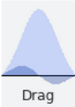

This pulse is constructed based on Gausian pulse with an additional Gaussian derivative component and lifting applied (Qiskit calles this parameter `beta`)

Qiskit provides a function which performs the Drag calibration for the rough estimation and fine tuning of the parameters (here we are interested only in the fine tuning calibration). This calibration routine tries to find the optimal parameters of the Gaussian derivative component in the pulse similar to Amplitude calibration.

In [42]:
# Similar to Amplitude calibration we use the build in calibration routines from qiskit for Drag calibration - FineXDragCal & FineSXDragCal
from qiskit_experiments.library import FineXDragCal, FineSXDragCal

jobs_data_drag_x = []
jobs_data_drag_sx = []

def FineDragCal_(qubit, repetitions=None):
    FineXDragCal_(qubit, repetitions)
    save_calibration(dummy_cals)
    FineSXDragCal_(qubit, repetitions)
    save_calibration(dummy_cals)

def FineXDragCal_(qubit, repetitions=None):
    drag_data = FineXDragCal(qubit, dummy_cals, backend=backend)
    print("\x1b[1;33mFineXDragCal\x1b[0m on qubit\x1b[1;31m", qubit, '\x1b[0musing', 'defualt' if repetitions is None else str(repetitions[:5])[:-1] + " ... " + str(repetitions[-5:])[1:], 'repetitions')
    if repetitions is not None:
        drag_data.set_experiment_options(repetitions=repetitions)
    job_data = drag_data.run().block_for_results()
    jobs_data_drag_x.append(job_data)
    
def FineSXDragCal_(qubit, repetitions=None):
    drag_data = FineSXDragCal(qubit, dummy_cals, backend=backend)
    print("\x1b[1;33mFineSXDragCal\x1b[0m on qubit\x1b[1;31m", qubit, '\x1b[0musing', 'defualt' if repetitions is None else str(repetitions[:5])[:-1] + " ... " + str(repetitions[-5:])[1:], 'repetitions')
    if repetitions is not None:
        drag_data.set_experiment_options(repetitions=repetitions)
    job_data = drag_data.run().block_for_results()
    jobs_data_drag_sx.append(job_data)

##### **Run**

Qiskit provides functions to perform amplitude and drag calibration automatically. We decided to calibrate only the used qubits (qubit 1, 3 and 5) using the following sequence:
1. Amplitude fine tuning for X gate with up to 14 gates in sequence (default qiskit settings).
2. Amplitude fine tuning for SX gate with up to 25 gates in sequence (default qiskit settings).
3. Drag calibration for X gate with up to 20 gates in sequence (default qiskit settings).
4. Drag calibration for SX gate with up to 20 gates in sequence (default qiskit settings).

<br/>

5. Amplitude fine tuning for X gate with up to 100 gates in sequence.
6. Amplitude fine tuning for SX gate with up to 100 gates in sequence.
7. Drag calibration for X gate with up to 50 gates in sequence.
8. Drag calibration for SX gate with up to 50 gates in sequence.


In [43]:
# Call our custom calibration functions.

# For every qubit used in the Ising model
for qubit in [1,3,5]:
    
    # Perform Amplitude calibration
    FineAmplitudeCal_(qubit)
    # and Drag calibration with default parameters.
    FineDragCal_(qubit)
    
# For every qubit used in the Ising model
for qubit in [1,3,5]:
    
    # Perform extended Amplitude and Drag calibration with higher repetitions for the calibration routines.
    FineAmplitudeCal_(qubit, x_repetitions=list(range(0,100)), sx_repetitions=[0, 1, 2]+list(range(3,100,2)))
    FineDragCal_(qubit, repetitions=list(range(0,50)))

# cleanup to reduce the memory usage
del jobs_data_amp_x
del jobs_data_amp_sx
del jobs_data_drag_x
del jobs_data_drag_sx

# We copy the calibration results from dummy_cals (calibration on which we run our FineAmplitudeCalibration & FineDragCalibration functions)
# to our global inst_map_cal which stores all instruction schedules defining our quantum gates.
update_inst_map_from_cal(qubits, ['sx','x'], dummy_cals, inst_map_cal)

FineXAmplitudeCal on qubit 1 using defualt repetitions
FineSXAmplitudeCal on qubit 1 using defualt repetitions
FineXDragCal on qubit 1 using defualt repetitions
FineSXDragCal on qubit 1 using defualt repetitions
FineXAmplitudeCal on qubit 3 using defualt repetitions
FineSXAmplitudeCal on qubit 3 using defualt repetitions
FineXDragCal on qubit 3 using defualt repetitions
FineSXDragCal on qubit 3 using defualt repetitions
FineXAmplitudeCal on qubit 5 using defualt repetitions
FineSXAmplitudeCal on qubit 5 using defualt repetitions
FineXDragCal on qubit 5 using defualt repetitions
FineSXDragCal on qubit 5 using defualt repetitions
FineXAmplitudeCal on qubit 1 using [0, 1, 2, 3, 4 ... 95, 96, 97, 98, 99] repetitions
FineSXAmplitudeCal on qubit 1 using [0, 1, 2, 3, 5 ... 91, 93, 95, 97, 99] repetitions
FineXDragCal on qubit 1 using [0, 1, 2, 3, 4 ... 45, 46, 47, 48, 49] repetitions
FineSXDragCal on qubit 1 using [0, 1, 2, 3, 4 ... 45, 46, 47, 48, 49] repetitions
FineXAmplitudeCal on qubit 3

In [8]:
print("values before calibration:\n")
display_gates_pulses(['x', 'sx'], [1, 3, 5], inst_map_ncal)
print("\nvalues after calibration:\n")
display_gates_pulses(['x', 'sx'], [1, 3, 5], inst_map_cal)

values before calibration:

Schedule((0, Play(Drag(duration=160, amp=(0.19150732139068202+0j), sigma=40, beta=-1.0054530603147216, name='Xp_d1'), DriveChannel(1), name='Xp_d1')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.0957200897300004+0.002092377730053873j), sigma=40, beta=-1.0433587543900116, name='X90p_d1'), DriveChannel(1), name='X90p_d1')), name="sx")
Schedule((0, Play(Drag(duration=160, amp=(0.19298442704742416+0j), sigma=40, beta=0.5816763009229303, name='Xp_d3'), DriveChannel(3), name='Xp_d3')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.09632095028761356-0.00017073802304731414j), sigma=40, beta=0.6649995699085924, name='X90p_d3'), DriveChannel(3), name='X90p_d3')), name="sx")
Schedule((0, Play(Drag(duration=160, amp=(0.186925035774377+0j), sigma=40, beta=-0.8470892572693323, name='Xp_d5'), DriveChannel(5), name='Xp_d5')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.09337050089223706+0.0013056107277884972j), sigma=40, beta=-0.8880862696302234,

#### Restore calibration

In case you need to restore previous calibration you can set `RESTORE_CALIBRATION=True` and provide the calibration directory

In [9]:
RESTORE_CALIBRATION = False
calibration_dir = "./gates_calibration/20220320-002545"
if RESTORE_CALIBRATION:
    library = FixedFrequencyTransmon(default_values={"duration": duration})
    dummy_cals = Calibrations.from_backend(backend, library)
    dummy_cals.load_parameter_values(calibration_dir + "/parameter_values.csv")

    print("values before calibration:\n")
    display_gates_pulses(['x', 'sx'], [1, 3, 5], inst_map_ncal)
    update_inst_map_from_cal(qubits, ['sx','x'], dummy_cals, inst_map_cal)
    print("\nvalues after calibration:\n")
    display_gates_pulses(['x', 'sx'], [1, 3, 5], inst_map_cal)

### Custom discriminator

We can improve the measurement fidelity by creating our own classifier, which based on the readout measurement classifies the final output into ground or excited state. We used the k-Nearest neighbor algorithm to improve the measurement outcome - we achieved an improvement of **1-2%** in the final fidelity. Other classifiers algorithms did not show significant improvements. Default readout fidelity for ibmq_jakarta is around 90% but our classifier improves the numbers to ~93%.

<br/>

The real outcome of a superconducting qubits computer are I and Q values of a microwave signal transmitted or reflected by the readout resonators. Those values are then mapped into ground and excited states, this is done by “discriminator”. Discriminator is a generic object which can take broad input values and classify them into predefined finate states.

Most common algorithms used as classifier:
* **k-Nearest Neighbors** - the object is classified most common class of its k nearest neighbors. This is a very simple technique but showing good results for quantum discriminators.
* support-vector machine (SVM) - we want to find the maximum-margin hyperplane that divides our input points into our classes. We can use linear functions to define the hyperplane or define non-linear kernels (ex. radial basis function kernel). The complexity for SVM is in order of $O(n^2)$. Quantum measurement often requires tens of thousands of shots to get an accurate readout, and creating a SVM classifier based on that number of samples is quite long.
Decision tree classifier - a tree structure object is created which splits the data into sub-trees with the final leafs of the tree pointing to the predicted class. This technique is very sensitive to the training data, if we don't have a broad enough distribution the decision tree classifier will not perform well (small change in the training data can result in large change in the tree), this is quite limiting for usage in quantum systems where slow drifts are changing the system.
* Neural networks - a black box model which consists of many layers of matrix operation, which is iteratively improved via gradient descent methods. Neural networks classifiers are showing great progress in many fields, and could be used to create better quantum discriminators.
* Naive Bayes - probabilistic classifiers which assign probability of specific class based on the input.

Example of measurements of ground (red) and excited (blue) states:

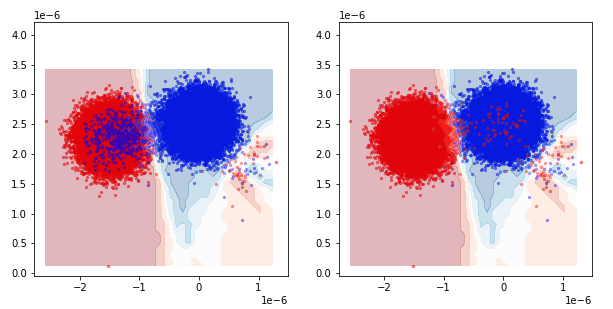

Both plots represent the same measurement but on the left side the excited state is plotted in front and on the right the ground state is plotted in the front. The background color coding is based on 10 nearest neighbors classifiers.

`measurement_circuit()` function creates the quantum circuits which results in ground and excited states:

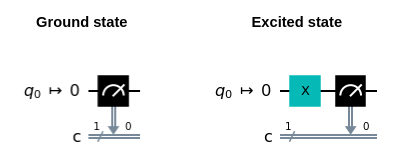

`add_measurement_cal()` function adds the custom discriminator and change the measurements pulse amplitude for the input schedules:

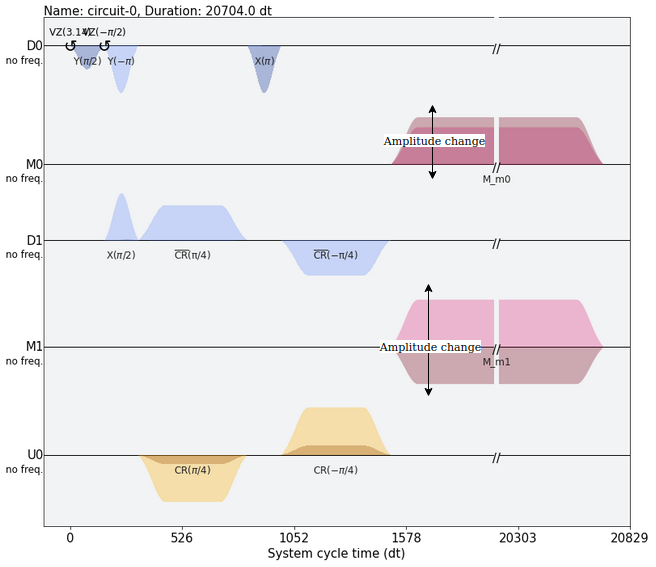

In [5]:
# Function to create the circuits for ground and excited state.
def measurement_circuit(qubits, final_state, delay=None):
    qc = QuantumCircuit(backend.configuration().n_qubits, len(qubits))
    
    # The excited state is generated by adding an X gate.
    if final_state == 'ext':
        qc.x(qubits)
        
    # Delay could be added if needed.
    if delay is not None:
        qc.delay(delay, qubits)
        
    # Add default measurement schedule which can be later updated with amplitude change or with custom discriminator.
    qc.measure(qubits, list(range(len(qubits))))
    
    # Return the quantum circuit
    return qc

from qiskit.ignis.measurement import SklearnIQDiscriminator

# This function updates the measurement parameters in the schedules. It can change the amplitude of the measurement pulse and add a custom discriminator.
def add_measurement_cal(schedule_qc, amp_mul=None, discriminators=None):
    if amp_mul is None:
        # Setup the default values.
        measurement_amp_mult = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
    else:
        # If amplitude multiplier (amp_mul) was given this value will be applied to all qubit pulses.
        measurement_amp_mult = [amp_mul]*7
      
    # If a discriminator object is provided then the amplitude multiplier (amp_mul) will be taken from the discriminator settings.
    if discriminators is not None:
        measurement_amp_mult = []
        for discr in discriminators:
            measurement_amp_mult.append(discr['settings']['amp_mul'])
    
    # Iterate through all input schedules.
    schedule_qc_ = []
    for sched_ in schedule_qc:
        
        # New schedule will be created and children will be copied from the initial schedule. This includes the schedule name which is needed for state tomography.
        new_sched_ = Schedule.initialize_from(sched_)
        
        # Iterate through all children's schedules.
        for time, inst in sched_.children:
            
            # Look for the AcquireChannel schedules - this indicates the measurement pulses, which we want to modify.
            if isinstance(inst.channels[0], AcquireChannel):
                
                # Create a new schedule (new_acquire_sched) which will be our amplitude modified pulse.
                new_acquire_sched_ = Schedule()
                for time_, inst_ in inst.children[1][1].children:
                    
                    # Look for the MeasureChannel and Play instruction.
                    if isinstance(inst_.channels[0], MeasureChannel) and isinstance(inst_, pulse.instructions.play.Play):
                        
                        # Now we insert a GaussianSquare pulse to our new_acquire_sched using the default parameters from the input schedule, with the exception of the amplitude which is multiplied by our custom value.
                        new_acquire_sched_.insert(time_, Play(GaussianSquare(duration=inst_.operands[0].duration, 
                                                                            amp=inst_.operands[0].amp * measurement_amp_mult[inst_.channel.index],
                                                                            sigma=inst_.operands[0].sigma, 
                                                                            width=inst_.operands[0].width, 
                                                                            name=inst_.operands[0].name), 
                                                             MeasureChannel(inst_.channel.index), name=inst_.name), inplace=True)
                    else:
                        # For the Acquire instruction we want to add a custom discriminator.
                        if isinstance(inst_, Acquire):
                            
                            # aq_idx is the qubit index on which we operate.
                            aq_idx = inst_.channels[0].index
                            
                            # If discriminators for this qubit were provided.
                            if discriminators is not None:
                                if discriminators[aq_idx] is not None:
                                    
                                    # Discriminator is taken from the function input.
                                    discriminator = discriminators[aq_idx]['discriminator']
                                    
                                    # We need to add to it a name - without this step we are getting an qiskit runtime error.
                                    discriminator.name = "quadratic_discriminator"
                                    
                                    # And we need to add parameters to avoid runtime errors.
                                    discriminator.params = {}
                                    
                                    # Now we insert the new Acquire instruction with our discriminator object.
                                    new_acquire_sched_.insert(time_, Acquire(inst_.operands[0], AcquireChannel(aq_idx), MemorySlot(inst_.operands[2].index), discriminator=discriminator), inplace=True)
                                
                                # If discriminators were not provided we insert to our new acquire schedule the parameters from the parent schedule.
                                else:
                                    new_acquire_sched_.insert(time_, inst_, inplace=True)
                            else:
                                # We insert the newly created acquire schedule (new_acquire_sched_) to our new modified schedule (new_sched_).
                                new_acquire_sched_.insert(time_, inst_, inplace=True)
                        else:
                            new_acquire_sched_.insert(time_, inst_, inplace=True)
                new_sched_.insert(time, new_acquire_sched_, inplace=True)
                
            else:
                new_sched_.insert(time, inst, inplace=True)
                
        # New schedules are returned.
        schedule_qc_.append(new_sched_)
    return schedule_qc_

We run measurement circuits (resulting in ground or excited state) with amplitudes ranging from the default value (1.0) up to 3x higher measurement amplitude.\
Those experiments are run on all qubits at the same time.

we use the `meas_level=1, meas_return='single', memory=True`to get the I & Q values from the readout resonators. This data will be used to create our classifiers.

In [20]:
# Arrays to store the job, circuits and schedules used for the benchmark.
jobs_discriminator = []
circuits_discriminator = []
schedules_discriminator = []

# Create the experiment settings.
experiments = [
    {'amp_mul': 1.0, 'qubits': qubits},
    {'amp_mul': 1.2, 'qubits': qubits},
    {'amp_mul': 1.4, 'qubits': qubits},
    {'amp_mul': 1.6, 'qubits': qubits},
    {'amp_mul': 1.8, 'qubits': qubits},
    {'amp_mul': 2.0, 'qubits': qubits},
    {'amp_mul': 2.2, 'qubits': qubits},
    {'amp_mul': 2.4, 'qubits': qubits},
    {'amp_mul': 2.6, 'qubits': qubits},
    {'amp_mul': 2.8, 'qubits': qubits},
    {'amp_mul': 3.0, 'qubits': qubits},
]

print("Running measurement amplitude calibration benchmarks:\n")

# For every experiment
for exp in experiments:
    
    # Create the quantum circuits in ground (qc_gnd) and excited states (qc_ext)
    qc_gnd = measurement_circuit(exp['qubits'], final_state='gnd', delay=0)
    qc_ext = measurement_circuit(exp['qubits'], final_state='ext', delay=0)
    
    # Convert the quantum circuit into schedules
    schedule_gnd = build_schedule(qc_gnd, backend, inst_map=inst_map_cal, method='alap')
    
    # Add measurement pulses according to our experiments
    schedule_gnd = add_measurement_cal([schedule_gnd], amp_mul=exp['amp_mul'])[0]
    
    schedule_ext = build_schedule(qc_ext, backend, inst_map=inst_map_cal, method='alap')
    schedule_ext = add_measurement_cal([schedule_ext], amp_mul=exp['amp_mul'])[0]

    print("Measurement amplitude multiplier", exp['amp_mul'], "on qubits", exp['qubits'])
    
    # Execute the job, returning the pure I, Q values from the readout (meas_levl=1, meas_return=’single’).
    job = execute([schedule_gnd, schedule_ext], backend, meas_level=1, meas_return='single', memory=True, shots=32000, optimization_level=0) #, default_meas_los=meas_los_freq)
    job.wait_for_final_state()
    
    # Store the job input and results into a global array.
    circuits_discriminator.append([qc_gnd, qc_ext])
    schedules_discriminator.append([schedule_gnd, schedule_ext]*4)
    job_monitor(job)
    jobs_discriminator.append(job)

Running measurement amplitude calibration benchmarks:

Measurement amplitude multiplier 1.0 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 1.2 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 1.4 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 1.6 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 1.8 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 2.0 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 2.2 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 2.4 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 2.6 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 2.8 on qubits [0, 1, 2, 3, 4, 5, 6]
Measurement amplitude multiplier 3.0 on qubits [0, 1, 2, 3, 4, 5, 6]


After gathering all the data, for every experiment (different measurement amplitude) we try creating an K-Neighbors classifier and we choose the best classifier for specific qubit.

Qubit:  0
Qubit:  1
Qubit:  2
Qubit:  3
Qubit:  4
Qubit:  5
Qubit:  6
0 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7f03a2aeab20>, 'score': 0.98240625, 'settings': {'duration': 22400, 'amp_mul': 2.2, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
1 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7f03a2cfcc40>, 'score': 0.979765625, 'settings': {'duration': 22400, 'amp_mul': 1.6, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
2 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7f03a2cfc310>, 'score': 0.98909375, 'settings': {'duration': 22400, 'amp_mul': 2.4, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
3 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7f03a2cfc070>, 'score': 0.983, 'settings': {'duration': 22400, 'amp_mul': 1.6, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
4 {'discri

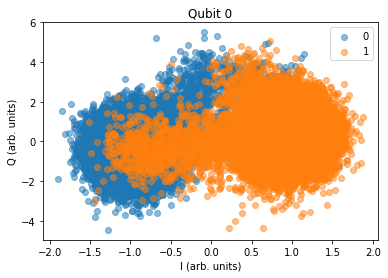

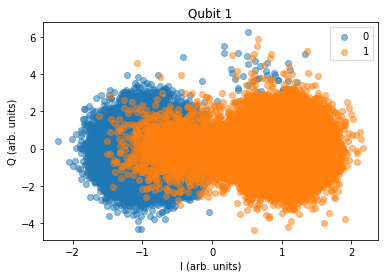

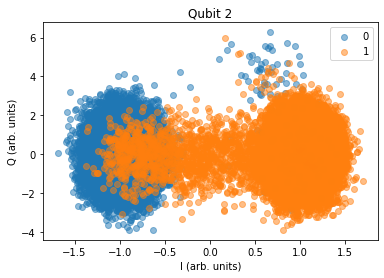

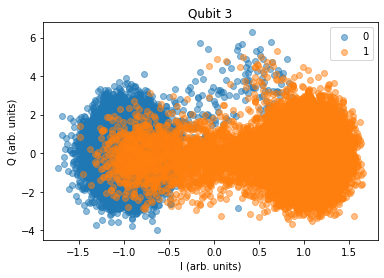

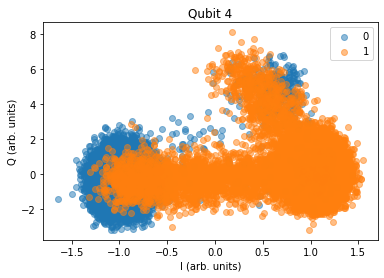

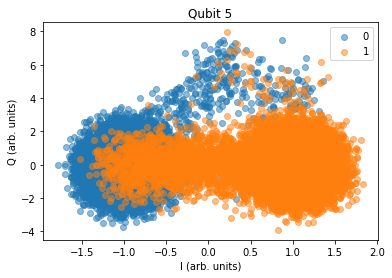

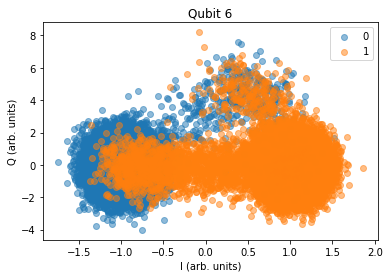

In [15]:
# Qiskit allows us to use sklearn classifiers.
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from qiskit.ignis.measurement import SklearnIQDiscriminator, QuadraticIQDiscriminator

# discriminators array will contain the best discriminator for every qubit.
discriminators = []
display_fig = False
scale_factor = 1e-14

# Iterate through all qubits
for qubit_idx in qubits:
    print("Qubit: ", qubits[qubit_idx])

    best_score = 0
    best_settings = None
    discriminator = None

    # Iterate through all experiments which we run. This will loop through all amplitudes which we checked.
    for job_idx, job in enumerate(jobs_discriminator):
        
        # Extract all the I,Q values for every execution for the ground and excited circuits.
        gnd_results = job.result().get_memory(0)[:, qubit_idx]*scale_factor
        exc_results = job.result().get_memory(1)[:, qubit_idx]*scale_factor

        # Split the real and imaginary parts of the quantum readout. The gnd_results array will have the shape:
        # (num_of_circuit_executions, 2), 
        # where [:, 0] is the real part and [:,1] is the imaginary part.
        gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
        exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])
        x = np.concatenate([gnd_results, exc_results])
        
        # y is our labels - 0 for the ground state and 1 for the excited states.
        y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
        
        # Create k-nearest neighbor classifier with k=100.
        classifier = KNeighborsClassifier(100)
        
        # Fit the model to our data.
        classifier.fit(x,y)
        
        # Check the classifier performance.
        score = classifier.score(x, y)

        # Through all the jobs iteration we want to select the best classifier. Everytime our classifier is better than the previous we store the better one.
        if score > best_score:
            if display_fig:
                plt.figure()
                fig, axs = plt.subplots(1, 2, figsize=(10, 10))
                axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
                axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
                axs[0].axis('square')

                axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
                axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
                axs[1].axis('square')

                x_min, x_max = x[:, 0].min(), x[:, 0].max()
                y_min, y_max = x[:, 1].min(), x[:, 1].max()
                xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))

                if hasattr(classifier, "decision_function"):
                    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
                else:
                    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                Z = Z.reshape(xx.shape)
                axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
                axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
                plt.show()
        
            best_score = score
            best_settings = experiments[job_idx]
            
            # Create the Sklearn based qiskit discriminator.
            discriminator = SklearnIQDiscriminator(KNeighborsClassifier(100), job.result(), [qubit_idx], expected_states=[0,1], standardize=True, schedules=schedules_discriminator[job_idx][:2])

    # After iterating through all the jobs - Store the discriminator into a global array with additional information about the settings which includes the best amplitude multiplier value.
    discriminators.append({'discriminator': discriminator, 'score': best_score, 'settings': best_settings})
    
for qubit in qubits:
    discriminators[qubit]['discriminator'].plot()
    print(qubit, discriminators[qubit])
    
# Store created discriminators locally, using pickle.
import pickle
timestr = time.strftime("%Y%m%d-%H%M%S")
if not os.path.exists("./discriminators"):
    os.makedirs("./discriminators")
pickle.dump(discriminators, open("./discriminators/discriminators_" + timestr + ".pickle", "wb"))

In case you need to restore previous custom discriminators you can set `RESTORE_DISCRIMINATORS=True` and provide the calibration directory

In [128]:
import pickle
RESTORE_DISCRIMINATORS = False
if RESTORE_DISCRIMINATORS:
    discriminators = pickle.load(open( "./discriminators/discriminators_20220320-012047.pickle", "rb"))

### Ising model

The CNOT gate is not native to superconducting quantum computer. The 2 qubits interaction is model by a so-called cross resonance gate.\
Often this cross resonance gate is transformed into CNOT or RZX gate which can be done by canceling additional interactions.\
This is done automatically by the `RZXCalibrationBuilder` object.

Here we create our custom function `rzx_cal()` to generate the RZX schedule - we use the defualt qiskit RZX schedule and modify it as needed.

Create RZX schedule:


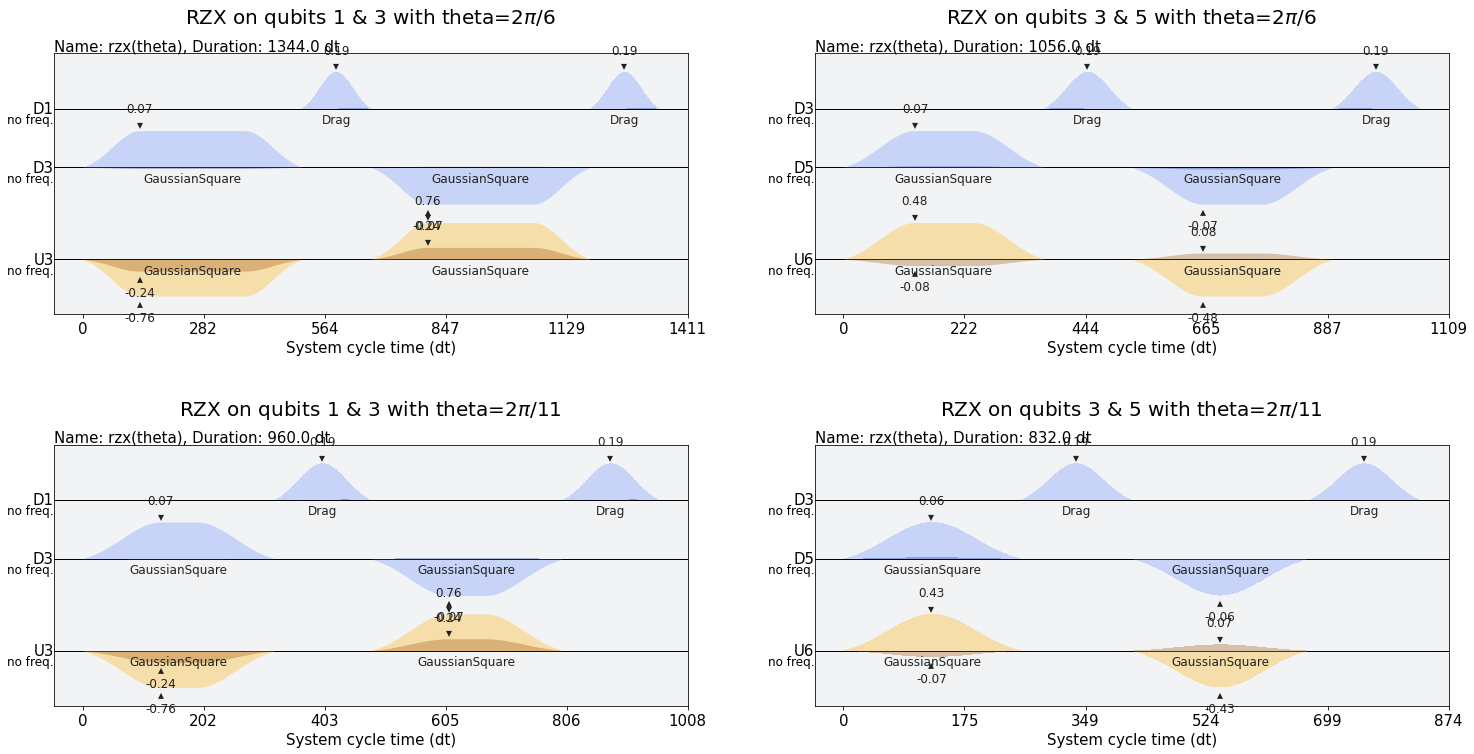

In [6]:
# Qiskit provides a Builder object which can be used to create custom RZX gates.
RzxCal = RZXCalibrationBuilder(backend=backend, instruction_schedule_map=inst_map_cal)
RzxCalNoEcho = RZXCalibrationBuilderNoEcho(backend=backend, instruction_schedule_map=inst_map_cal)

# IBM systems accept duration in multiples of 16, so we create a helper function.
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# This function returns the RZX schedule based on the input angle (theta), additional parameters can be provided for custom calibration.
def rzx_cal(qubits, theta, amp_mul=1.0, amp=None, amp_t=None, duration=None, sigma=None, x_cal=False, waveform=None):
    # Create the RZX angle and
    theta_ = Instruction('theta', 7, 7, params=[theta])
    # generate the rzx schedule.
    def_rzx_cal = RzxCal.get_calibration(theta_, qubits)
    
    # We will extract the default algorithms from the rzx schedule
    amp_dr_, amp_ctr_, sigma_, width_, duration_, ctr_ch_, dr_ch_ = None, None, None, None, None, None, None
    x_amp_, x_beta_, x_sigma_, x_duration_, x_dr_ch_ = None, None, None, None, None
    
    for instr_ in def_rzx_cal.instructions:
        if isinstance(instr_[1], pulse.instructions.play.Play):
            
            # Go through all RZX instructions and look for the GaussianSquare pulse.
            if isinstance(instr_[1].operands[0], pulse.GaussianSquare):
                
                # If the pulse is acting on ControlChannel,
                if isinstance(instr_[1].channel, pulse.channels.ControlChannel):
                    # CR control
                    if amp_ctr_ is None:
                        
                        # For the Control Channel,
                        # if the control channel parameters are not yet set,
                        # copy the pulse amplitude and the channel
                        amp_ctr_ = instr_[1].operands[0].amp
                        ctr_ch_ = instr_[1].channel.index
                else:
                    #CR drive
                    if amp_dr_ is None:
                        
                        # For the Drive Channel,
                        # if the drive channel parameters are not yet set,
                        # copy all the pulse parameters to local objects.
                        amp_dr_ = instr_[1].operands[0].amp
                        sigma_ = instr_[1].operands[0].sigma
                        duration_ = instr_[1].operands[0].duration
                        width_ = instr_[1].operands[0].width
                        dr_ch_ = instr_[1].channel.index
                        
            # If the pulse is Drag - this is the X gates,
            if isinstance(instr_[1].operands[0], pulse.Drag):
                # X pulses
                if x_amp_ is None:
                    
                    # copy the data x pulse data if the parameters are not not yet set.
                    x_duration_ = instr_[1].operands[0].duration
                    x_amp_ = instr_[1].operands[0].amp
                    x_beta_ = instr_[1].operands[0].beta
                    x_dr_ch_ = instr_[1].channel.index
                    x_sigma_ = instr_[1].operands[0].sigma
    
    # If the input amplitude is provided, update the local pulse parameters with the input amplitude.
    if amp is not None:
        if amp[0] is not None:
            amp_ctr_ = amp[0]+amp_ctr_.imag*1j
        if amp[1] is not None:
            amp_ctr_ = amp_ctr_.real+amp[1]
            
    if amp_t is not None:
        if amp_t[0] is not None:
            amp_dr_ = amp_t[0]+amp_dr_.imag*1j
        if amp_t[1] is not None:
            amp_dr_ = amp_dr_.real+amp_t[1]
                       
    if duration is not None:
        # If the duration is provided, update the local pulse parameters - for the duration set it to the closest multiple of 16.
        duration = get_closest_multiple_of_16(duration)
        
        # Calculated pulse width based on the new duration.
        width_ = duration/duration_ * width_
        duration_ = duration
        
    # If sigma is provided, update the local pulse parameters.
    if sigma is not None:
        sigma_ = sigma
        
    # If the x gate calibration is provided, copy its parameters to the local object, by default RzxCal.get_calibration() uses the ibmq machine default X gate calibrations.
    if x_cal:
        x_cal = inst_map_cal.get('x', x_dr_ch_)
        x_amp_, x_beta_, x_sigma_, x_duration_ = x_cal.instructions[0][1].operands[0].amp, x_cal.instructions[0][1].operands[0].beta, \
                                                 x_cal.instructions[0][1].operands[0].sigma, x_cal.instructions[0][1].operands[0].duration
        
    # Update the pulse amplitude based on the amplitude multiplier provided as input.
    amp_ctr_ *= amp_mul
    amp_dr_ *= amp_mul

    if waveform is None:
        # Create a new RZX schedule with the local parameters.
        rzx_cal = Schedule((0, Play(GaussianSquare(duration=duration_, amp=amp_dr_, sigma=sigma_, width=width_), DriveChannel(dr_ch_))),
                       (0, Play(GaussianSquare(duration=duration_, amp=amp_ctr_, sigma=sigma_, width=width_), ControlChannel(ctr_ch_))),
                       (duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       (duration_+x_duration_, Play(GaussianSquare(duration=duration_, amp=-amp_dr_, sigma=sigma_, width=width_), DriveChannel(dr_ch_))),
                       (duration_+x_duration_, Play(GaussianSquare(duration=duration_, amp=-amp_ctr_, sigma=sigma_, width=width_), ControlChannel(ctr_ch_))),
                       (2*duration_+x_duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       name="rzx(theta)")
    else:
        # custom waveform is supported
        rzx_cal = Schedule((0, Play(Waveform(waveform), ControlChannel(ctr_ch_))),
                       (duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       (duration_+x_duration_, Play(Waveform([-x for x in waveform]), ControlChannel(ctr_ch_))),
                       (2*duration_+x_duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       name="rzx(theta)")
        
    # Return the rzx schedule.
    return rzx_cal

print("Create RZX schedule:")
fig, axs = plt.subplots(2, 2, figsize=(25, 12))
fig.subplots_adjust(hspace=0.5)
axs[0, 0].set_title("RZX on qubits 1 & 3 with theta=$2\pi / 6$\n", fontsize=20)
axs[0, 1].set_title("RZX on qubits 3 & 5 with theta=$2\pi / 6$\n", fontsize=20)
rzx_cal(qubits=(1,3), theta=2*np.pi/6, amp_mul=1.0, x_cal=True).draw(style=IQXDebugging(), axis=axs[0, 0])
rzx_cal(qubits=(3,5), theta=2*np.pi/6, amp_mul=1.0, x_cal=True).draw(style=IQXDebugging(), axis=axs[0, 1])

axs[1, 0].set_title("\n\nRZX on qubits 1 & 3 with theta=$2\pi / 11$\n", fontsize=20)
axs[1, 1].set_title("\n\nRZX on qubits 3 & 5 with theta=$2\pi / 11$\n", fontsize=20)
rzx_cal(qubits=(1,3), theta=2*np.pi/11, amp_mul=1.0, x_cal=True).draw(style=IQXDebugging(), axis=axs[1, 0])
rzx_cal(qubits=(3,5), theta=2*np.pi/11, amp_mul=1.0, x_cal=True).draw(style=IQXDebugging(), axis=axs[1, 1])


We created function `ising_sim()` which returns the quantum circuits for the Ising simulation based on the input parameters.

The main parameters for this function are:
 * `trotter_steps` - number of Trotter steps used in the circuit.
 * `target_time` - the final simulation time.
 * `optimization_level` - the optimization level which will be passed to the transpiler. It should be set to "0" especially for the ZNE simulation.
 * `circ_type` - create the circuit based on `'rzx'` or `'cnot'` gates.
 * `calibrated` - should we use the calibrated `inst_map`?
 * `zne_pattern` - the pattern which defines where in the Ising simulation we apply Identity operators. This allows us to create noise scaling needed for ZNE.
 
The RZX based 2 qubit Ising model is:

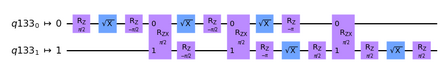

And for CNOT simulation we use the 3xCNOT decomposition:

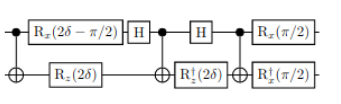


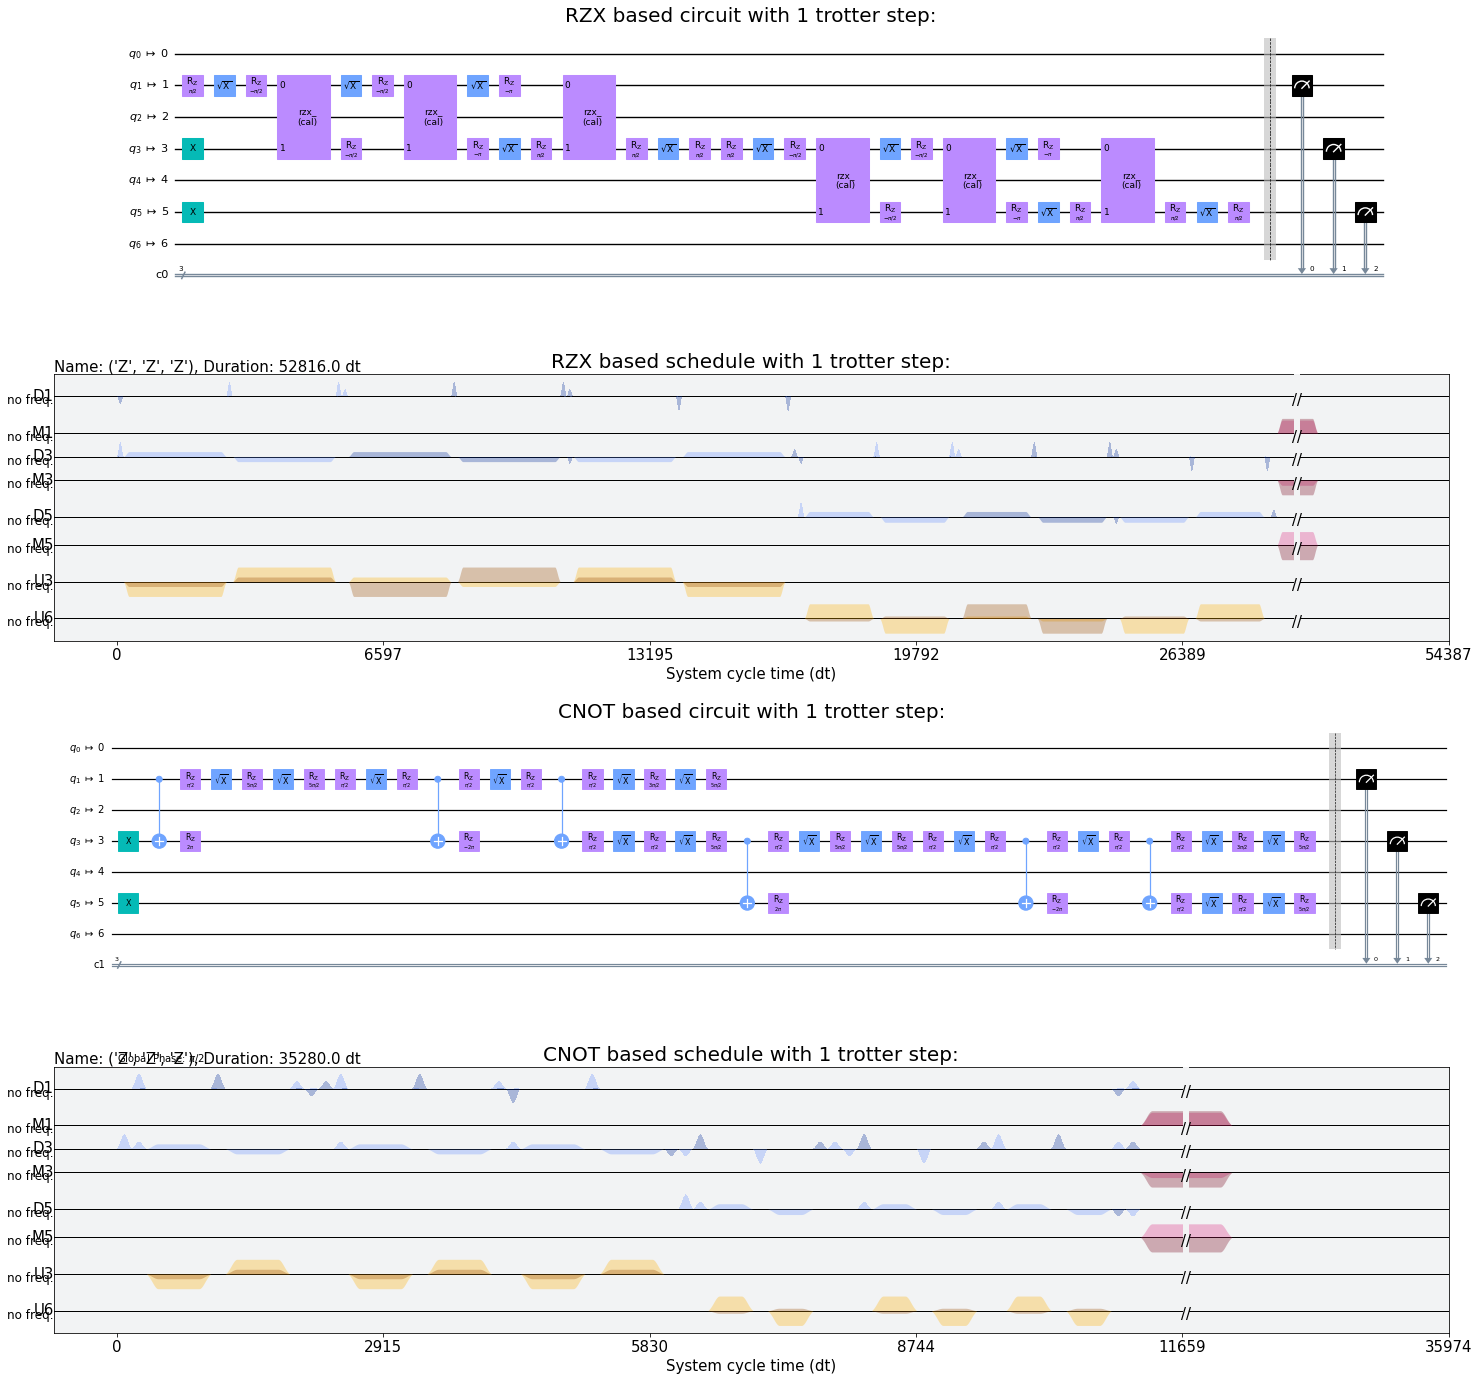

In [7]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# This function generates the state tomography circuits for the Ising simulation. Trotter steps and target time are the input arguments used to generate the circuit.
# circ_type can be ‘cnot’ or ‘rzx’
# calibration argument defines if a calibrated instance map shall be used.
def ising_sim(trotter_steps, target_time, optimization_level, circ_type, 
              calibrated=False, zne_pattern=[]):
    
    # Define the used qubits.
    q0 = 1
    q1 = 3
    q2 = 5
    num_qubits = 3
    
    # We will split the full Ising simulation into smaller 2 qubits Ising circuits.
    Ising2Q_qr = QuantumRegister(2)
    Ising2Q_qc = QuantumCircuit(Ising2Q_qr, name='Ising_2Qubits')
    
    # create the CNOT circuit
    if circ_type == 'cnot':
        t = Parameter('t')
        
        Ising2Q_qc.cnot(0,1)
        Ising2Q_qc.rx(2 * t - np.pi/2, 0)
        Ising2Q_qc.h(0)
        Ising2Q_qc.rz(2 * t, 1)
        Ising2Q_qc.cnot(0,1)
        Ising2Q_qc.h(0)
        Ising2Q_qc.rz(-2 * t, 1)
        Ising2Q_qc.cnot(0,1)
        Ising2Q_qc.rx(np.pi/2,0)
        Ising2Q_qc.rx(-np.pi/2,1)
        
    # create the RZX circuit
    if circ_type == 'rzx':
        rzx_gate = Gate('rzx_', 2, [])
        
        Ising2Q_qc.rz(np.pi/2, 0)
        Ising2Q_qc.sx(0)
        Ising2Q_qc.rz(-np.pi/2, 0)

        Ising2Q_qc.append(rzx_gate, [0, 1])
        Ising2Q_qc.sx(0)
        Ising2Q_qc.rz(-np.pi/2, 0)
        Ising2Q_qc.rz(-np.pi/2, 1)

        Ising2Q_qc.append(rzx_gate, [0, 1])
        Ising2Q_qc.sx(0)
        Ising2Q_qc.rz(-np.pi, 0)
        Ising2Q_qc.rz(-np.pi, 1)
        Ising2Q_qc.sx(1)
        Ising2Q_qc.rz(np.pi/2, 1)

        Ising2Q_qc.append(rzx_gate, [0, 1])
        Ising2Q_qc.h(1)
        
    Ising2Q = Ising2Q_qc.to_instruction()
    
    # If the ZNE pattern was provided, create the Inverse circuits.
    if len(zne_pattern) != 0:
        Ising2Q_inv_qr = QuantumRegister(2)
        Ising2Q_inv_qc = QuantumCircuit(Ising2Q_qr, name='Ising_inv_2Qubits')

        # Inverse CNOT trotter step
        if circ_type == 'cnot':
            Ising2Q_inv_qc.rx(-np.pi/2,0)
            Ising2Q_inv_qc.rx(np.pi/2,1)
            Ising2Q_inv_qc.cnot(0,1)
            Ising2Q_inv_qc.h(0)
            Ising2Q_inv_qc.rz(2 * t, 1)
            Ising2Q_inv_qc.cnot(0,1)
            Ising2Q_inv_qc.h(0)
            Ising2Q_inv_qc.rz(-2 * t, 1)
            Ising2Q_inv_qc.rx(-2 * t + np.pi/2, 0)
            Ising2Q_inv_qc.cnot(0,1)
            
        # Inverse Rzx trotter step
        if circ_type == 'rzx':
            rzx_inv_gate = Gate('rzx_inv_', 2, [])
            
            Ising2Q_inv_qc.h(1)
            Ising2Q_inv_qc.append(rzx_inv_gate, [0, 1])
            
            Ising2Q_inv_qc.sx(0)
            Ising2Q_inv_qc.rz(-np.pi, 0)
            Ising2Q_inv_qc.rz(np.pi/2, 1)
            Ising2Q_inv_qc.sx(1)

            Ising2Q_inv_qc.append(rzx_inv_gate, [0, 1])
            
            Ising2Q_inv_qc.rz(-np.pi/2, 0)
            Ising2Q_inv_qc.sx(0)
            Ising2Q_inv_qc.rz(-np.pi, 0)
            Ising2Q_inv_qc.rz(np.pi/2, 1)

            Ising2Q_inv_qc.append(rzx_inv_gate, [0, 1])
            Ising2Q_inv_qc.rz(-np.pi/2, 0)
            Ising2Q_inv_qc.sx(0)
            Ising2Q_inv_qc.rz(np.pi/2, 0)
            
        Ising2Q_inv = Ising2Q_inv_qc.to_instruction()
    
    # Create the full ising circuit.
    qc = QuantumCircuit(7)
    
    # Apply X gate to get the |110> state.
    qc.x([q1,q2])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    for step in range(trotter_steps):
        
        # For every trotter step.
        # Add the 2 Qubit Ising sim for the first qubits.
        qc.append(Ising2Q, [q0, q1])
        
        # If the ZNE pattern for this trotter step is set.
        # Apply the inverse and standard 2 Qubit Ising circuit to increase the noise. The number of repetition of the inverse and standard circuits are defined in the zne_pattern array.
        if len(zne_pattern) > step:
            for _ in range(2, int(zne_pattern[step][0])+1):
                qc.append(Ising2Q_inv, [q0, q1])
                qc.append(Ising2Q, [q0, q1])
                
        qc.append(Ising2Q, [q1, q2])
        if len(zne_pattern) > step:
            for _ in range(2, int(zne_pattern[step][1])+1):
                qc.append(Ising2Q_inv, [q1, q2])
                qc.append(Ising2Q, [q1, q2])
        
    # Select the global inst map calibration.
    inst_map_ = inst_map_cal if calibrated else inst_map_ncal
    
    # For the rzx gate we need to add a custom schedule from rzx_cal() custom function.
    if circ_type == 'rzx':
        # We create the schedule for the rzx qubit 1 & 2 and rzx qubit 2 & 3.
        rzx_q0q1_sched = rzx_cal((q0,q1), 2*target_time/trotter_steps, amp_mul=1.00, x_cal=True)
        rzx_q1q2_sched = rzx_cal((q1,q2), 2*target_time/trotter_steps, amp_mul=1.00, x_cal=True)
        
        # qc.add_calibration() applies our schedule to the custom Gate.
        qc.add_calibration('rzx_', (q0,q1), rzx_q0q1_sched)
        qc.add_calibration('rzx_', (q1,q2), rzx_q1q2_sched)
        
        # We add it to the instant calibration map for the transpiler.
        inst_map_.add('rzx_', (q0,q1), rzx_q0q1_sched)
        inst_map_.add('rzx_', (q1,q2), rzx_q1q2_sched)
        
        # add the inverse RZX gates calibration
        if len(zne_pattern) != 0:
            rzx_inv_q0q1_sched = rzx_cal((q0,q1), -2*target_time/trotter_steps, amp_mul=1.00, x_cal=True)
            rzx_inv_q1q2_sched = rzx_cal((q1,q2), -2*target_time/trotter_steps, amp_mul=1.00, x_cal=True)
            qc.add_calibration('rzx_inv_', (q0,q1), rzx_inv_q0q1_sched)
            qc.add_calibration('rzx_inv_', (q1,q2), rzx_inv_q1q2_sched)
            inst_map_.add('rzx_inv_', (q0,q1), rzx_inv_q0q1_sched)
            inst_map_.add('rzx_inv_', (q1,q2), rzx_inv_q1q2_sched)
    
    # For the cnot circuit bind the delta (t) parameter.
    if circ_type == 'cnot':
        if trotter_steps > 0:
            qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Create the state tomography circuits.
    qpt_qcs = state_tomography_circuits(qc, [q0, q1, q2])
    
    # Transpile the circuit into quantum gates available on the device.
    qpt_qcs = transpile(qpt_qcs, backend, optimization_level=optimization_level, basis_gates=inst_map_.instructions)

    # Return the tomography circuits and the “calibrated or not” instruction map for further usage.
    return qpt_qcs, inst_map_

fig, axs = plt.subplots(4, figsize=(25, 24))
fig.subplots_adjust(hspace=0.3)
axs[0].set_title("RZX based circuit with 1 trotter step:", fontsize=20)
qpt_qcs, inst_map_ = ising_sim(1, np.pi, 0, 'rzx')
qpt_qcs[-1].draw(fold=-1, ax=axs[0])
axs[1].set_title("RZX based schedule with 1 trotter step:", fontsize=20)
schedule(qpt_qcs[-1], backend, inst_map=inst_map_, method='alap').draw(axis=axs[1], show_waveform_info=False, show_framechange=False)

qpt_qcs, inst_map_ = ising_sim(1, np.pi, 0, 'cnot')
axs[2].set_title("CNOT based circuit with 1 trotter step:", fontsize=20)
qpt_qcs[-1].draw(scale=0.5, fold=-1, ax=axs[2])
axs[3].set_title("CNOT based schedule with 1 trotter step:", fontsize=20)
schedule(qpt_qcs[-1], backend, inst_map=inst_map_, method='alap').draw(axis=axs[3], show_waveform_info=False, show_framechange=False)

### Dynamical Decoupling

Qiskit provides a Pass Manager object which can apply DD patterns but we see problems with custom modified schedules which we created for the X gate calibration in RZX schedule and custom measurement classifier which will be explained later. We create our custom function which adds DD pulses into a preexisting schedule.

Dynamic decoupling provides a significant boost in the performance of the quantum circuit - **~3-5%**.

<br/>

All physical qubits in a quantum computer are susceptible to decoherence and one of the techniques to reduce the qubits environmental coupling is dynamic decoupling (DD). It is a series of periodic control pulses (most often in form of X or Y gates). 
Dynamical decoupling (DD) is a form of quantum error suppression that modifies the system-environment interaction so that its overall effects are very
nearly self-canceling, thereby decoupling the system evolution from that of the noise-inducing environment.

Assuming that the Hamiltonian of the system is $H = H_B+H_{SB}$, where $H_B$ includes all bathonly terms and $H_{SB}$ includes all terms acting non-trivially on the system. The idea behind DD is to allow the system to evolve under the Hamiltonian dynamics and then applying a DD control pulse which refocuses the evolution towards the error-free ideal state.

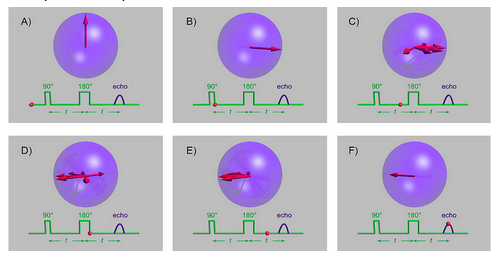


Every pulse introduces a single qubit error so the number of pulses in every sequence needs to be balanced in terms of gains of the DD schema and the noise for the pulses / gates.


Install additional free libraries for the Dynamical Decoupling patterns from [Q-CTRL Open Control](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/index.html).

In [8]:
# Install qctrl-open-control package to have access to predefine DD sequences.
!pip install qctrl-open-controls
!pip install qctrl-visualizer

  Using cached qctrl_open_controls-9.0.0-py3-none-any.whl (37 kB)
  Using cached qctrl_visualizer-2.12.2-py3-none-any.whl (31 kB)


We created a custom function `add_dd()` to add DD patterns.

For the Ising simulation we want to apply the DD pattern when the qubits are not used:

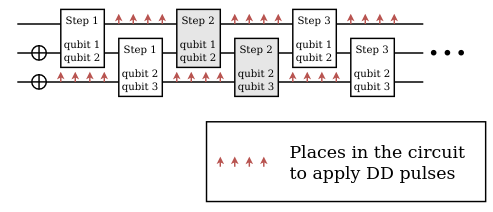

We decided to implement the following DD patterns:

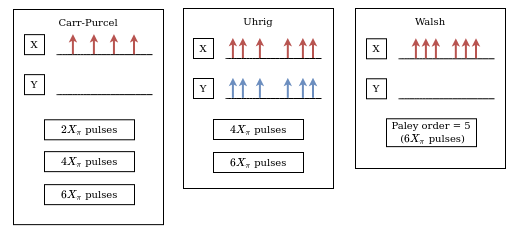

For the Uhrig sequency we only apply the X gates.

  0%|          | 0/1 [00:00<?, ?it/s]

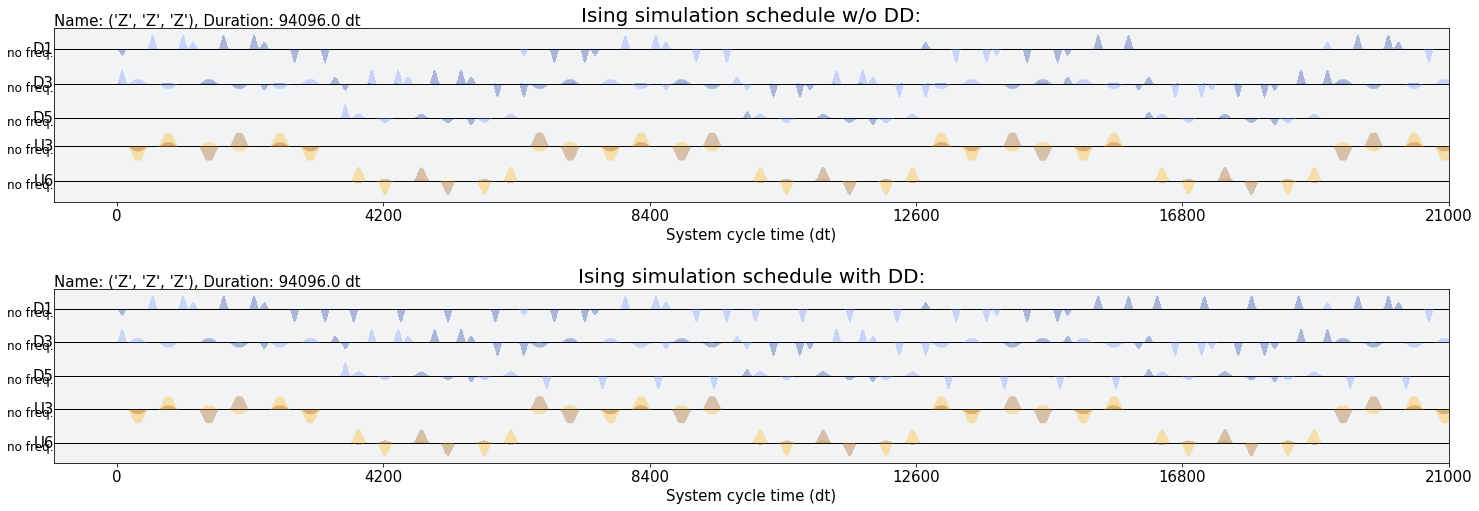

In [9]:
# Import DD sequences.
from qctrlopencontrols import (new_carr_purcell_sequence,
                               new_uhrig_sequence,
                               new_walsh_sequence
                              )

# Core function takes schedules as an input and returns the schedules with added DD sequences.
def add_dd(schedules, pattern="Walsh_Paley5"):
    
    # Create the new schedules array.
    new_schedules = []
    pbar = tqdm(total=len(schedules))
    
    # Iterate through the input schedules.
    for schedule in schedules:
        time_slots_for_dd = []
        instructions = schedule.instructions
        
        # Iterate through the instruction in the schedule.
        for idx, inst in enumerate(instructions):
            
            # If the instruction is on the DriveChannel
            if isinstance(inst[1].channel, pulse.channels.DriveChannel):
                
                # store its DriveChannel index (qubit on which the instruction acts).
                chn = inst[1].channels[0].index
                
                # Iterate through the next instruction to find the next instruction acting on the same DriveChannel index (qubit).
                for idx_, inst_ in enumerate(instructions[idx+1:]):
                    if isinstance(inst_[1].channel, pulse.channels.DriveChannel):
                        
                        # If the channels are equal that means we found the instruction for qubit X and the next instruction on the same qubit.
                        chn_ = inst_[1].channels[0].index
                        if chn == chn_:
                            
                            # Now we can find the delay between instructions on this qubit.
                            time_delta = inst_[0] - (inst[0] + inst[1].duration)
                            
                            # If the time is greater than our threshold (here hardcoded to 2000) store the time information to add DD sequences in the next steps
                            if time_delta > 2000:
                                time_slots_for_dd.append({'start_time': inst[0] + inst[1].duration, 'duration': time_delta, 'channel': chn})
                            
                            # Break the loop looking for the second instruction.
                            break

        # After the iteration through instruction is finished we have the time_slots_for_dd array with time slices on which we can apply DD.
        new_sched = Schedule.initialize_from(schedule)
        
        # Create our new schedule based on the initial one.
        for time, inst in schedule.children:
            
            # Insert all instructions for the initial schedule to our new one to have the schedule duplicated.
            new_sched.insert(time, inst, inplace=True)
            
        # For every time slot with a delay.
        for dd_slot in time_slots_for_dd:
            
            # dd_ will be our Xpi pulse schedule from the global instruction map.
            dd_ = inst_map_cal.get('x', dd_slot['channel'])
            
            # Get the DD parameters from the qctrl-open-controls package.
            dds = None
            if pattern == "Walsh_Paley5":
                dds = new_walsh_sequence(duration=dd_slot['duration'], paley_order = 5.,name='Walsh DDS')
            elif pattern == "CP_n2":
                dds = new_carr_purcell_sequence(duration=dd_slot['duration'], offset_count = 2.,name='Carr-Purcell DDS')
            elif pattern == "CP_n4":
                dds = new_carr_purcell_sequence(duration=dd_slot['duration'], offset_count = 4.,name='Carr-Purcell DDS')
            elif pattern == "CP_n6":
                dds = new_carr_purcell_sequence(duration=dd_slot['duration'], offset_count = 6.,name='Carr-Purcell DDS')
            elif pattern == "Uhrig_n4":
                dds = new_uhrig_sequence(duration=dd_slot['duration'], offset_count = 4.,name='Uhrig DDS')
            elif pattern == "Uhrig_n6":
                dds = new_uhrig_sequence(duration=dd_slot['duration'], offset_count = 6.,name='Uhrig DDS')
                
            # We are interested only in the pulse positions (dds.offsets array).
            for offset in dds.offsets:
                
                # For every offset time we append our Xpi pulse schedule.
                new_sched.insert(int(dd_slot['start_time'] + offset - dd_.duration/2), dd_, inplace=True)
                
        new_schedules.append(new_sched)
        pbar.update(1)
    pbar.close()
    
    # Return the updated schedule.
    return new_schedules

fig, axs = plt.subplots(2, figsize=(25, 8))
fig.subplots_adjust(hspace=0.5)
axs[0].set_title("Ising simulation schedule w/o DD:", fontsize=20)
qpt_qcs, inst_map_ = ising_sim(11, np.pi, 0, 'rzx')
schedule_qc = schedule(qpt_qcs[-1], backend, inst_map=inst_map_, method='alap')
schedule_qc.draw(time_range=[0,20000], show_waveform_info=False, show_framechange=False, axis=axs[0])

# add DD patterns
schedule_qc = add_dd([schedule_qc], pattern='CP_n4')[0]
axs[1].set_title("Ising simulation schedule with DD:", fontsize=20)
schedule_qc.draw(time_range=[0,20000], show_waveform_info=False, show_framechange=False, axis=axs[1])

### Measurement filter

Qiskit provides a measurement fitter routine which performs full Hilbert space measurement and creates a filter which reduces the bias of the system. This routine brings high improvement in the final fidelity for a cost of 1 additional circuit. The improvement is around **2-5%**.

In [129]:
# Import the standard qiskit functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

# Create the measurement circuits for the full Hilbert Space measurements. 
meas_calibs, state_labels = complete_meas_cal(qubit_list=[1,3,5], qr=7, circlabel='mcal')
meas_calibs_schedules = schedule(meas_calibs, backend, inst_map=inst_map_cal, method='alap')

# COMMENT if you dont want to use custom discriminators
meas_calibs_schedules = add_measurement_cal(meas_calibs_schedules, discriminators=discriminators)

# UNCOMMENT if you dont want to use custom discriminators
# meas_calibs_schedules = add_measurement_cal(meas_calibs_schedules)

# Execute the circuits.
job_cal = execute(meas_calibs_schedules, backend=backend, shots=32000)

# Create the fitter object which contains the error mitigation parameters.
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

readout_fidelity: 0.9307460937500001


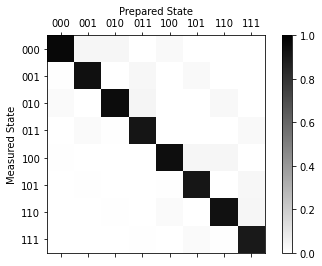

In [132]:
# custom discriminator
print("readout_fidelity:", meas_fitter.readout_fidelity())
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

### ZNE

The idea behind Zero Noise Estimation is that all our circuits have an inherent noise $\lambda$ and it is possible to increase this noise by to $\lambda' = c$ where $c>1$. By exploring the same circuit but with different noise levels it is possible to extrapolate the $\lambda=0$ results.
The two most common techniques to scale the noise are:
* Increasing the pulse duration for the gates which increase the overall time execution.
* Unitary folding - Replacing the subcircuit $G$ with new circuits: $G G^{\dagger}G$.
* Replacing CNOT gates with 3xCNOT (Unitary folding only for CNOT gates).

The unitary folding technique is one of the simplest and easiest to implement. The default circuits noise scale is 1, by adding unitary folding for the whole circuit we increase the noise scale to 3, adding additional unitary folding steps increases the noise scale to 5:

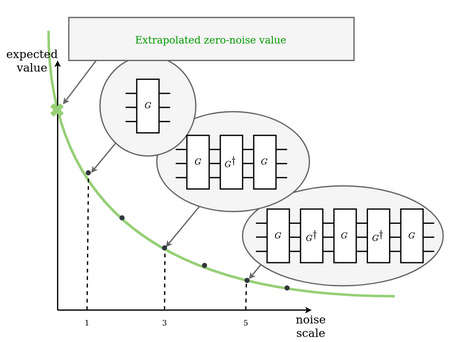

Every trotterization step can be considered a seperate circuit which we can fold. This allows us to generate circuits noise scale in between 1 and 3 giving more interpolation steps:

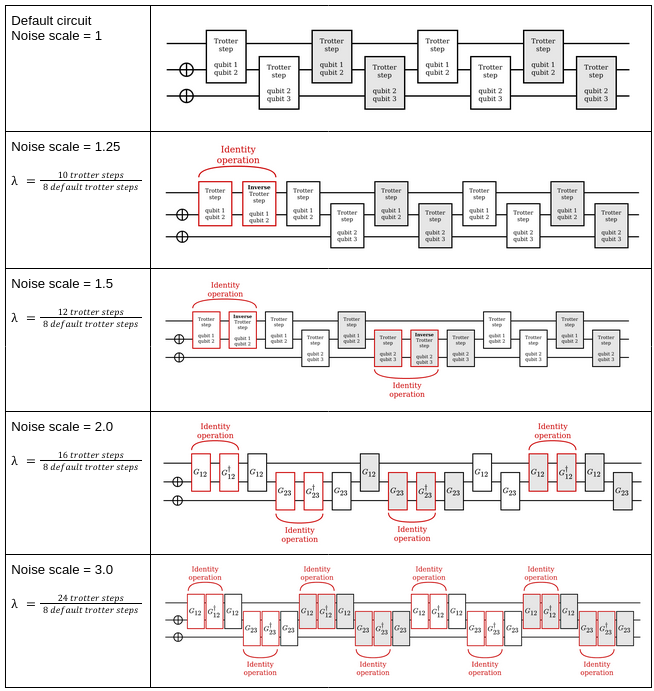


Underfull Vlist: [Vlist <2.82 3.18 0.00 0.00> Hrule Glue [Hlist <2.82 3.00 0.00 0.00> Hbox [Hlist <2.06 3.00 0.00 0.00> `X` k0.06] Hbox]]
Underfull Vlist: [Vlist <2.82 3.18 0.00 0.00> Hrule Glue [Hlist <2.82 3.00 0.00 0.00> Hbox [Hlist <2.06 3.00 0.00 0.00> `X` k0.06] Hbox]]


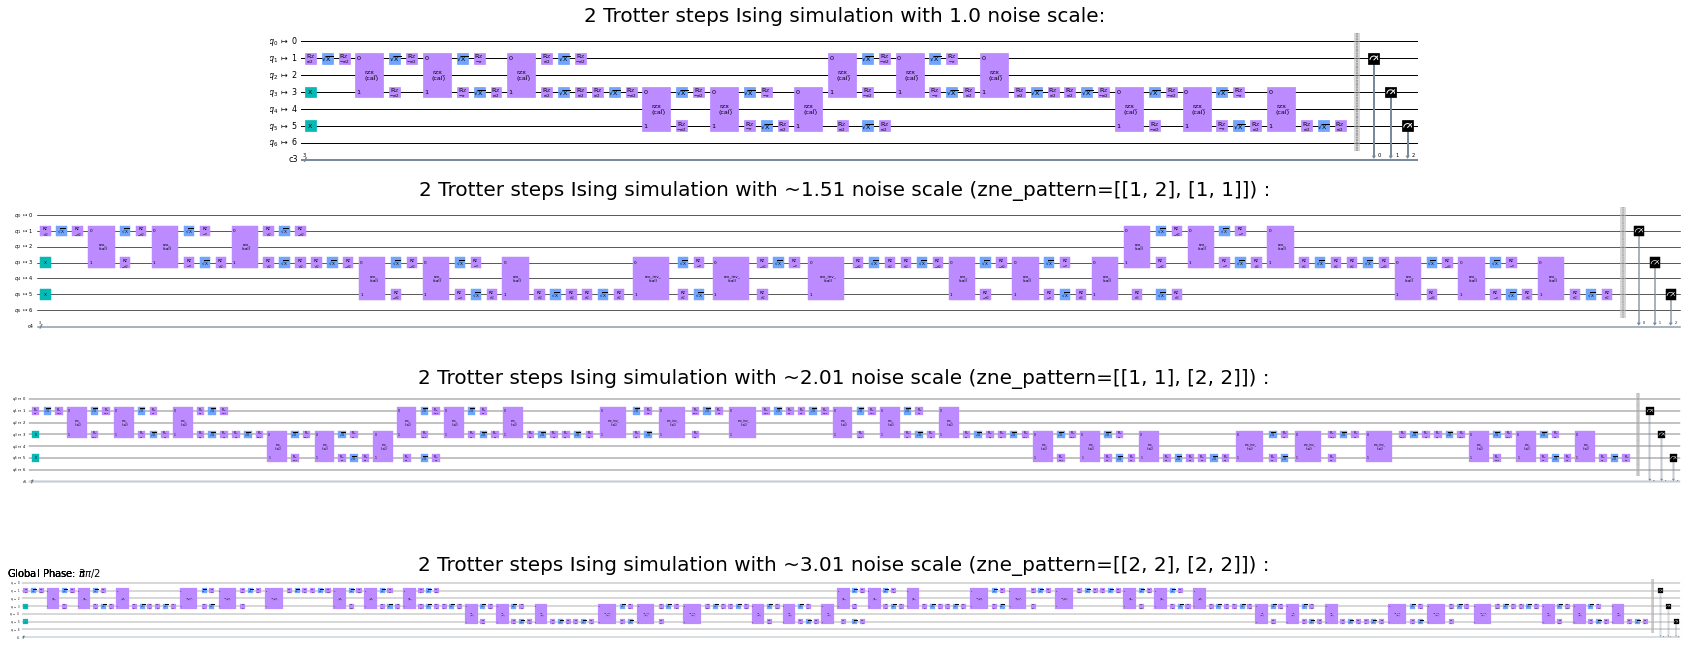

In [11]:
def generate_zne_pattern(trotter_steps, noise):
    # Right now only noise scaling up to 3 is only supported due to already high noise in the Ising simulation circuit. 
    # We are able to generate many intermediate steps from 1 to 3 noise scales. 
    # This is sufficient to have enough samples for the extrapolation.
    if noise > 3.01:
        raise NotImplementedError("noise higher than 3.01 is not yet implemented")
        
    # Number of circuits in one trotter steps if we don't apply any noise 
    # (pattern 11, noise for single qubit pair pattern 12 and noise for both qubit pairs - pattern 22)
    circuits_in_11_patern = 2 # zne without noise has 2 circuits for every trotter steps (G01, G12)
    circuits_in_12_patern = 4 # zne with noise only applied to one ising circuit has 4 circuits (G01, Gd01, G01,G12)
    circuits_in_22_patern = 6 # zne with noise on both ising circuits has 6 circuits (G01, Gd01, G01, G12, Gd12, G12)

    # Look for the minimal number of 22 patterns which are needed to generate the expected noise scaling.
    for num_of_22_patterns in range(trotter_steps, -1, -1):
        zne_score = num_of_22_patterns*circuits_in_22_patern + (trotter_steps-num_of_22_patterns)*circuits_in_11_patern
        if noise > zne_score / (trotter_steps*circuits_in_11_patern):
            break
    
    # After calculating the number of 22 patterns, check how many 12 patterns can we apply.
    for num_of_12_patterns in range(trotter_steps, -1, -1):
        zne_score = num_of_12_patterns*circuits_in_12_patern + (trotter_steps-num_of_12_patterns-num_of_22_patterns)*circuits_in_11_patern + num_of_22_patterns*circuits_in_22_patern
        if noise > zne_score / (trotter_steps*circuits_in_11_patern):
            break
    
    # zne_pattern array will have the final ZNE sequence.
    zne_pattern = [[1,1]]*trotter_steps
    steps = list(range(0, trotter_steps))
    
    # Assign 22 and 12 patterns to random trotter steps.
    for _ in range(0, num_of_22_patterns):
        rnd_step = random.randint(0, len(steps)-1)
        zne_pattern[steps[rnd_step]] = [2,2]
        steps.pop(rnd_step)
    for _ in range(0, num_of_12_patterns):
        rnd_step = random.randint(0, len(steps)-1)
        if random.random() > 0.5:
            zne_pattern[steps[rnd_step]] = [1,2]
        else:
            zne_pattern[steps[rnd_step]] = [2,1]
        steps.pop(rnd_step)

    return zne_pattern, num_of_12_patterns, num_of_22_patterns
        
fig, axs = plt.subplots(4, figsize=(30, 12))
axs[0].set_title("2 Trotter steps Ising simulation with 1.0 noise scale:", fontsize=20)
qc, _ = ising_sim(trotter_steps=2, target_time=np.pi, optimization_level=0, circ_type='rzx', zne_pattern=[])
qc[-1].draw(fold=-1, ax=axs[0])

zne_pattern_, _, _ = generate_zne_pattern(trotter_steps=2, noise=1.51)
axs[1].set_title("2 Trotter steps Ising simulation with ~1.51 noise scale (zne_pattern="+str(zne_pattern_)+") :", fontsize=20)
qc, _ = ising_sim(trotter_steps=2, target_time=np.pi, optimization_level=0, circ_type='rzx', zne_pattern=zne_pattern_)
qc[-1].draw(fold=-1, ax=axs[1])

zne_pattern_, _, _ = generate_zne_pattern(trotter_steps=2, noise=2.01)
axs[2].set_title("2 Trotter steps Ising simulation with ~2.01 noise scale (zne_pattern="+str(zne_pattern_)+") :", fontsize=20)
qc, _ = ising_sim(trotter_steps=2, target_time=np.pi, optimization_level=0, circ_type='rzx', zne_pattern=zne_pattern_)
qc[-1].draw(fold=-1, ax=axs[2])

zne_pattern_, _, _ = generate_zne_pattern(trotter_steps=2, noise=3.01)
axs[3].set_title("2 Trotter steps Ising simulation with ~3.01 noise scale (zne_pattern="+str(zne_pattern_)+") :", fontsize=20)
qc, _ = ising_sim(trotter_steps=2, target_time=np.pi, optimization_level=0, circ_type='rzx', zne_pattern=zne_pattern_)
qc[-1].draw(fold=-1, ax=axs[3])

### Run experiments

In [10]:
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    # print(tomo_fitter.data)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
 
    return fid

In [168]:
timestr = time.strftime("%Y%m%d-%H%M%S")

circuits = []
jobs = []

# target time for the simulation
target_time = np.pi
# set to True to use calibrated gate parameters - inst_map_cal, False use default ibm parameters
calibrated_ = True
# set to True to add custom discriminator
meas_calibrated_ = True
# specify the DD pattern set to None to not include DD sequences.
dd_pattern_ = "CP_n4"
# number of trotter steps
steps_ = 11

# create experiments configuration which we want to run
experiments = \
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.00)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.15)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.43)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.58)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.86)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.01)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.29)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.43)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.72)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.86)[0], "comment": ""}]

# UNCOMMENT for smaller number of ZNE circuits.
# experiments = \
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.00)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.43)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.86)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.29)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.72)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=3.01)[0], "comment": ""}]

def execute_circuit(target_time):
    circuits = []
    inst_map_ = None
    # for every experiment generate the quantum circuit and add all experiments to the circuits list
    for idx, exp in enumerate(experiments):
        qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
        circuits.extend(qc)

    # convert quantum circuits to schedules
    schedule_qc = schedule(circuits, backend, inst_map=inst_map_, method='alap')
    print("schedules prepared")

    # add custom discriminator if needed
    if exp['calibrated_meas']:
        schedule_qc = add_measurement_cal(schedule_qc, discriminators=discriminators)
        print("measurement calibration added")
    # add DD patterns if needed
    if exp['dd'] is not None:
        schedule_qc = add_dd(schedule_qc, pattern=exp['dd'])
        print("dynamic decoupling added")
    
    # set the number of shots. Optimization_level needs to be set to 0, meas_level needs to be set to 2.
    job = execute(schedule_qc, backend, meas_level=2, shots=16000, optimization_level=0)
    print("circuit schedule for execution")
    print("")
    print(str(job.job_id()) + "\t" + str(experiments) + "\n")
    if not os.path.exists("./benchmarks"):
        os.makedirs("./benchmarks")
    with open("./benchmarks/" + "ZNE_single_Jackarta_real_benchmark" + timestr + ".tsv", 'a+') as f:
        # store the job_id if we want to retreive it later and the experiments setup which we used to recreate circuits for state tomography.
        f.write(str(job.job_id()) + "\t" + str(experiments) + "\n")
    
    # UNCOMMENT if you want the code to wait for the job results, due to long wait times it is prefered to use backend.retrive_job()
    # job.wait_for_final_state()
    # job_monitor(job)
    return job, circuits, schedule_qc

jobs, circuits, _ = execute_circuit(target_time)

schedules prepared
measurement calibration added


  0%|          | 0/270 [00:00<?, ?it/s]

dynamic decoupling added
circuit schedule for execution

6252e99ffdf3778532570c90	[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'ca

### Restore measurement filter

<font color='red'>Change the `job_id`</font> to your measurement filter if needed (`backend.retrive_job(<job id>)`) \
or skip this section if the measurement filter is created.

readout_fidelity: 0.9307460937500001


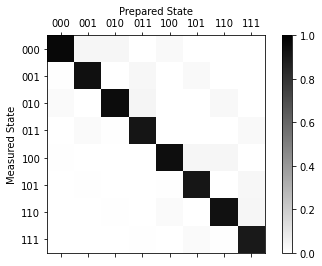

In [14]:
job_cal = backend.retrieve_job("6236837219e689c3d1c7f97f") # update if needed

from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

# code to recreate the meas_fitter object
meas_calibs, state_labels = complete_meas_cal(qubit_list=[1,3,5], qr=7, circlabel='mcal')
meas_calibs_schedules = schedule(meas_calibs, backend, inst_map=inst_map_cal, method='alap')
meas_calibs_schedules = add_measurement_cal(meas_calibs_schedules, discriminators=discriminators)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

print("readout_fidelity:", meas_fitter.readout_fidelity())
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

### Ising simulation results

Restore previous job

<font color='red'>Change the `job_id`</font> in the `backend.retrieve_job()` and <font color='red'>add the `experiments` array</font> if you want to restore previously run job. \
If the `job` and `circuits` are created you can skip this section.

In [15]:
jobs = backend.retrieve_job("623754a3d97bff37d8693572")
experiments = [{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

Use the ZNE noise scaling circuits for all the tomography steps to estimate the noise free state results.

We will update the `jobs.results()` object with the ZNE extrapolation results. This new results object we call `zne_result`.\
When the extrapolater result is lower than "0" count we set the final extrapolated value to "0".

The best results was achieved with exponential extrapolation function: $A e^{-x}+B$. 

[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1

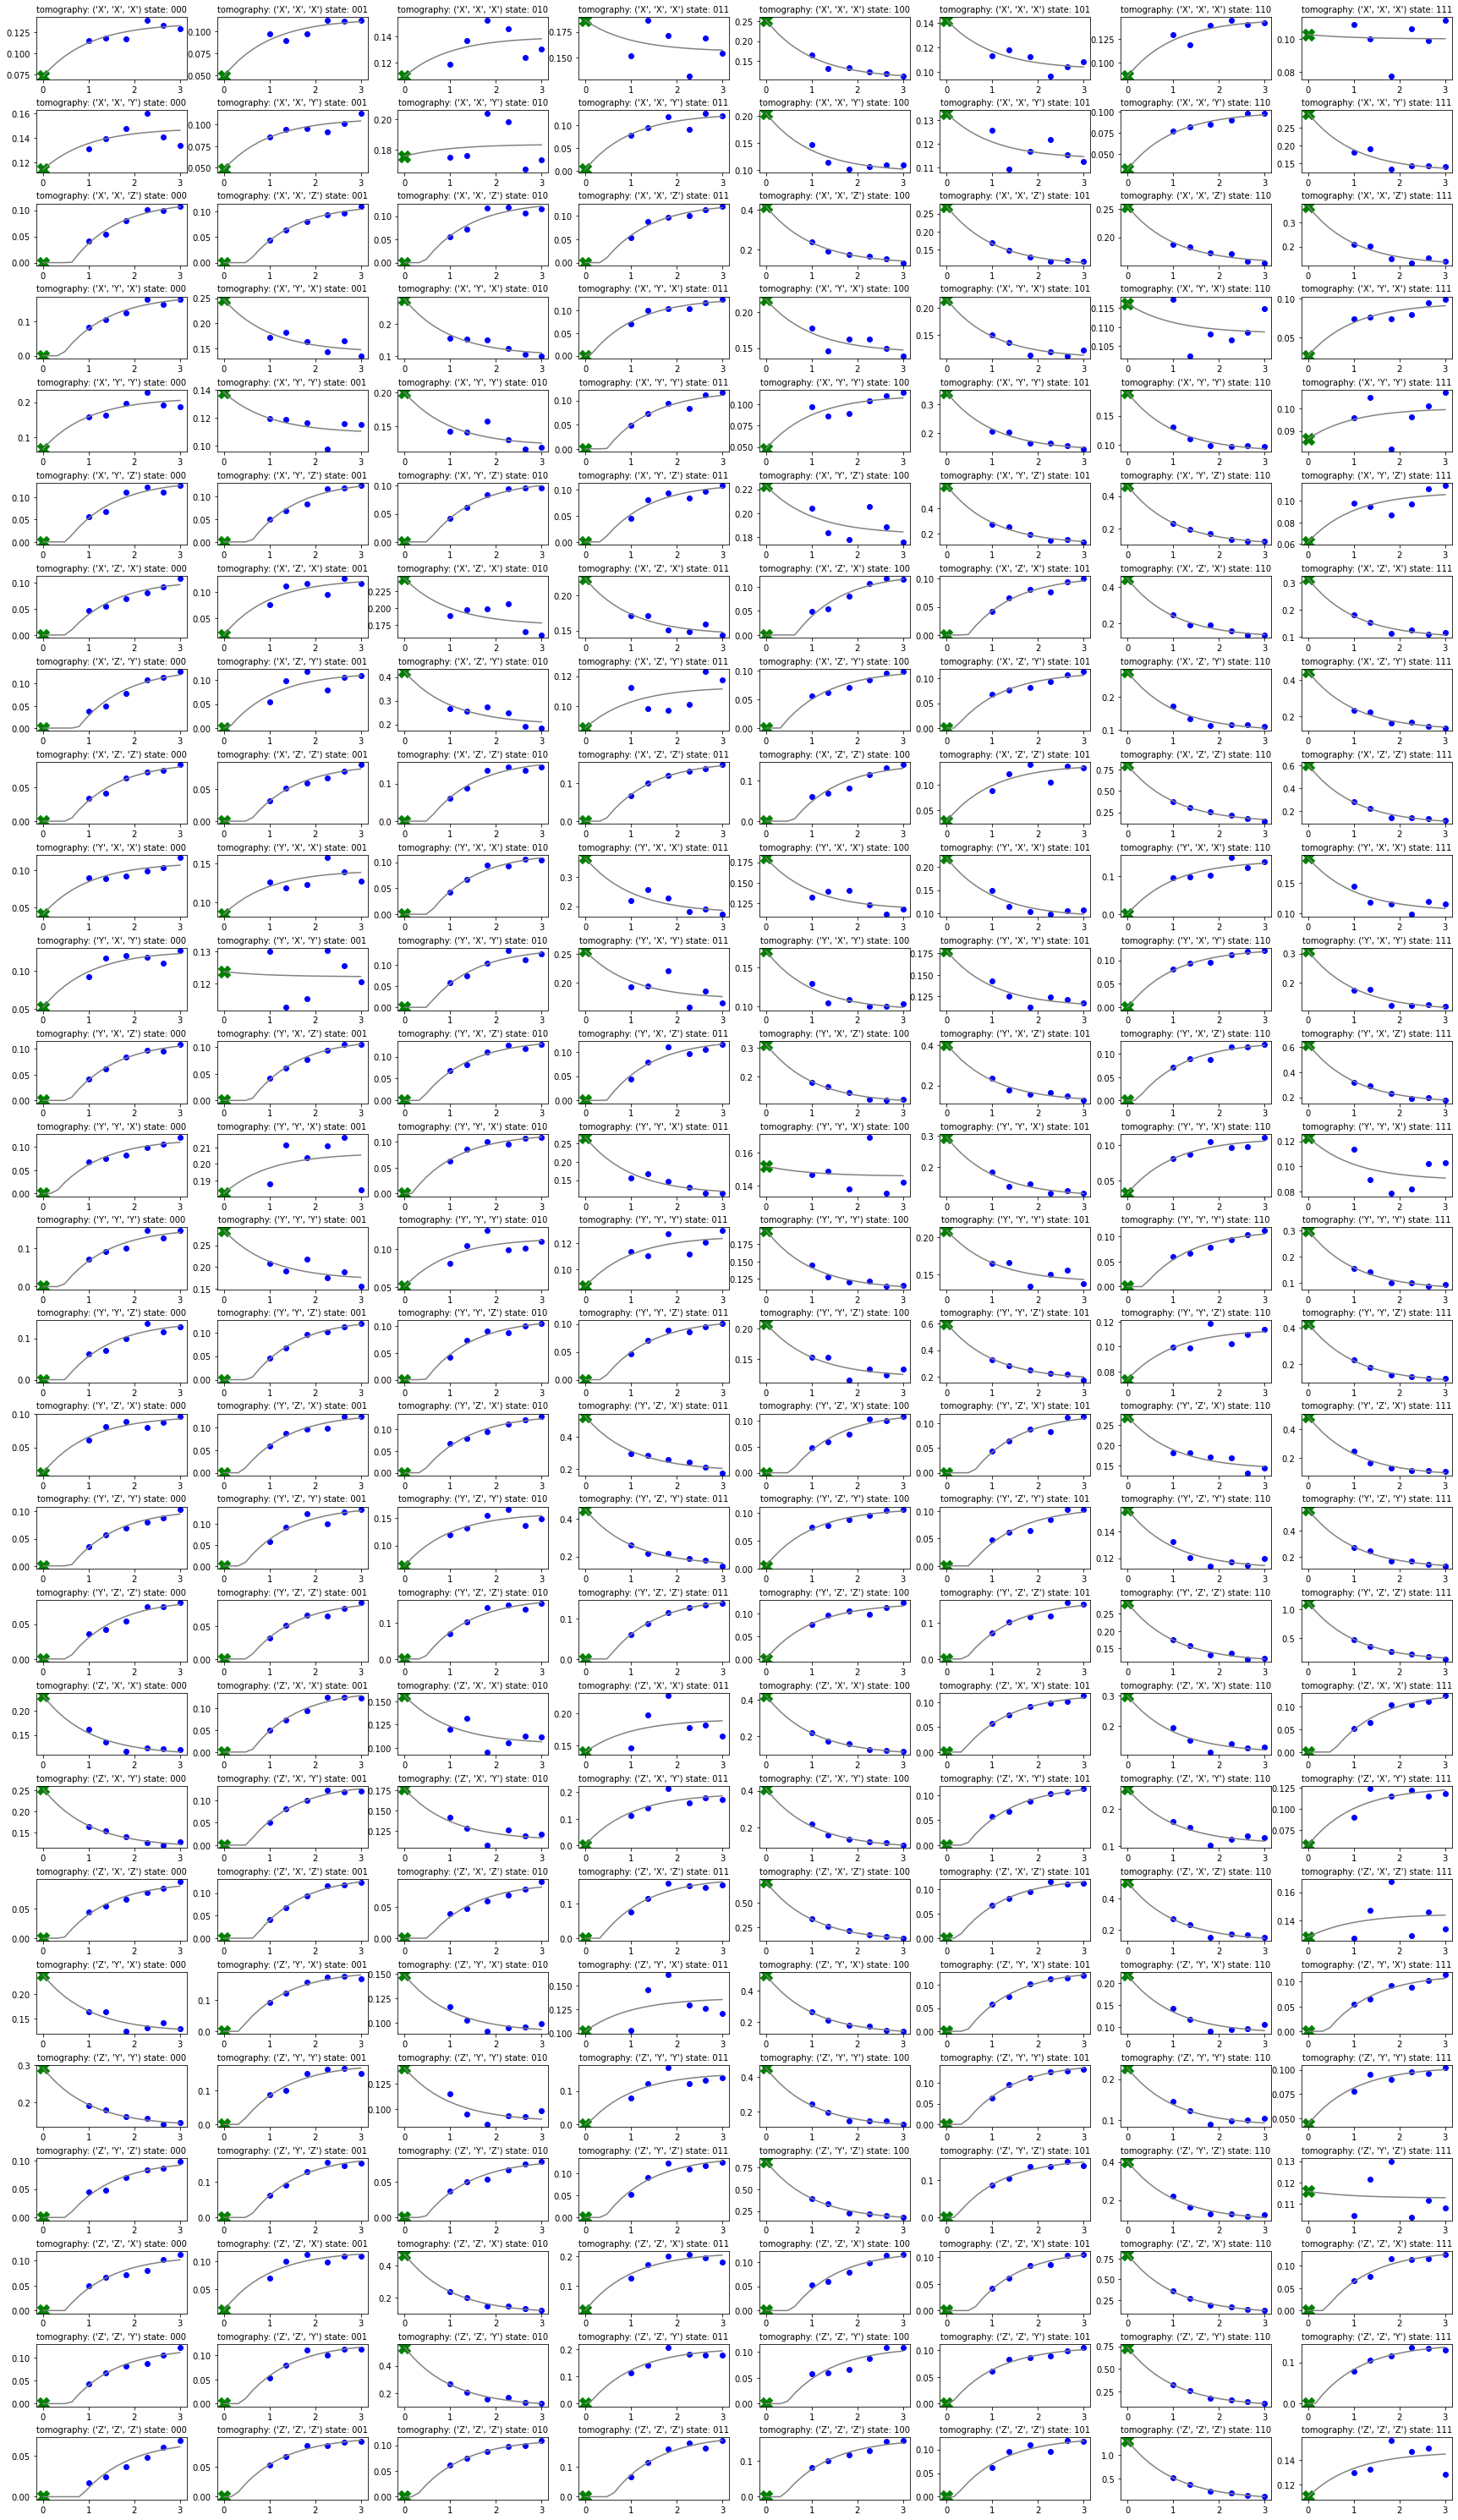

In [16]:
# curve_fit returns the best parameters values for the extrapolation function based on the input points (ZNE samples).
from scipy.optimize import curve_fit
# copy is used to create new Result object
import copy

# Do we want to apply measurement filter?
measurement_filter = True

# Exponential function will be used for the extrapolation.
zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

# Number of tomography circuits 3^(number of measured qubits).
num_tomo_circ = 3**3

# Set to True to display the extrapolation visualization.
display_fig = True

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))
    fig.subplots_adjust(hspace=0.5)

# Create a copy of the Result object used as an input for StateTomographyFitter().
zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

# Index of the experiment in which circuit without noise was run (this will be used to see the performance between final result with and without ZNE).
circuit_without_noise_idx = 0

# Create a copy of the Results object with the direct quantum measurements.
unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    # apply measurement filter.
    mitigated_results = meas_filter.apply(jobs.result())
    
    # Create a copy of the Results with measurement filter applied.
    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)
print("")

# Iterate through all tomography measurements.
for tomo_circ_idx in range(0, num_tomo_circ):   
    exp_results = {}
    
    # Iterate through all qubit states. We will update those state results with ZNE.
    for qubits_state in jobs.result().get_counts()[-1]:
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        # Iterate through all experiments - that is circuits with different noise scales.
        for idx, exp in enumerate(experiments): 
            
            # Calculate the noise scale (zne_noise) based on the number of Ising circuits repetitions.
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern]
            zne_noise = sum(zne_coef) / len(zne_coef)
            
            # If the noise scale is 1.0 we store the index of the experiment.
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
                ax.set_title("tomography: "+str(jobs.result().to_dict()['results'][tomo_circ_idx]['header']['name']) +" state: "+ str(qubits_state), fontsize=10)

            # expected_state is the number of measurements in a specific state.
            expected_state = 0
            try:
                # Use the mitigated or direct results.
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
                
            # Store the scale noise as “x” and store the expected state for specific qubit state as “y”.
            x.append(zne_noise)
            y.append(expected_state)

        # Find the optimal extrapolation function parameters for the scale noise and qubit state.
        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        # Extrapolate the ZNE results into other scale noise, the extrapolated result at x=0 will be our zero noise scale result.
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        fit_data = [x if x>0 else 0 for x in fit_data]
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, color='grey')
            ax.scatter(0, fit_data[0] if fit_data[0] >= 0 else 0, color='green', marker='X', s=200)
        zne_counts = int(fit_data[0]*shots)
        
        # Store the zero noise scale result into exp_results object. If the extrapolation result is below 0 set it to 0. 
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    # Based on the extrapolated results update a new Result object (zne_result).
    for key in sorted(exp_results):
        
        # We store the job results into a dictionary.
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        
        # We update the dictionary counts data without our updated estimation.
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        
        # We apply the new results by using the .from_dict() function to populate the Result object.
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

# UNCOMMENT to view the (Z,Z,Z) measurements results
# print('zne_result:', zne_result.get_counts()[-1])
# print('w/o zne results:', unmittigated_result.get_counts()[-1])

# Calculate fidelity by passing zne_result object and run standard state tomography with the original circuit to have a comparison.
fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:\x1b[0;32m\t\t\t\t\t", fid, "\x1b[0m")
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:\x1b[0;36m\t", fid, "\x1b[0m")
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:\x1b[0;36m\t\t\t\t\t", fid, "\x1b[0m")